In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import xgboost as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=0

In [3]:
print FOLD

0


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True,with_l3=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                                                            ,
                    'l2_3000_ridge_fold{}_False_d478.pkl', 'l2_3003_conv_fold{}_False_d478.pkl', 'l2_3001_lgb_fold{}_False_d478.pkl', 'l2_3006_xgb_fold{}_False_d478.pkl'                   
                    
                   ])

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,max_depth=4,subsample=1,C=0.1,
                                    learning_rate=0.02,min_child_weight=1,objective='reg:l1f0',
                                     gamma=0,reg_alpha=0,reg_lambda=1 ):
        models=[]
        scores=[]
        d_train = lgb.DMatrix(trainX, label=trainy)
        d_valid = lgb.DMatrix(validX, label=validy)
        
        if 1:
            params = {}
            params['eta'] = learning_rate
            params['objective'] = objective
            params['eval_metric'] = 'rmse'
            params['max_depth'] = max_depth
            params['colsample_bytree'] = colsample_bytree
            params['subsample'] = subsample
            params['min_child_weight'] = min_child_weight 
            params['gamma'] = gamma            
            params['reg_alpha'] = reg_alpha            
            params['reg_lambda'] = reg_lambda            
            params['silent'] = 1
            params['nthread'] = 8
            params['tree_method']='hist'
            print i, params
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]
            
            gbm = lgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=50)


            models.append(gbm)
            validpred=gbm.predict(d_valid,ntree_limit=gbm.best_ntree_limit)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(d_train,ntree_limit=gbm.best_ntree_limit)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    d_test = lgb.DMatrix(testX, label=testy)    
    test_pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        d_test = lgb.DMatrix(X)    
        pred=model.predict(d_test,ntree_limit=model.best_ntree_limit).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    d_test = lgb.DMatrix(X)    
    pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)

    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'learning_rate': 0.02,
 'max_depth': 8,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'subsample': 1}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
def ff(offset):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    #validpreds[offset]=[validpred,pred478]
    return offset, [validpred,pred478]
    #pickle.dump(validpreds, open('3005_rf_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [24]:
j=FOLD
validpreds={}

In [25]:
p = Pool(1,maxtasksperchild=1)



1
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200571, 2) (50169, 2)
train/valid # (200571, 2) (50169, 2)
rand split across time
train has 200571 records out of 389630 records
valid has 50169 records out of 389630 records
train has 5803 records out of 5803 records
no valid set
1566
0
(200571, 1, 32) (200571, 7, 32) (200571, 1) (200571, 1)
(200571, 256) (200571,) (200571,)
(50169, 1, 32) (50169, 7, 32) (50169, 1) (50169, 1)
(50169, 256) (50169,) (50169,)
(5803, 1, 32) (5803, 7, 32) (5803, 1) (5803, 1)
(5803, 256) (5803,) (5803,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39538	valid-rmse:2.38789
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.985307	valid-rmse:0.985237
[100]	train-rmse:0.575839	valid-rmse:0.583589
[150]	train-rmse:0.491978	valid-rmse:0.50617
[200]	train-rmse:0.475899	valid-rmse:0.494665
[250]	train-rmse:0.470396	valid-rmse:0.493077
[300]	train-rmse:0.466654	valid-rmse:0.492881
[350]	train-rmse:0.463225	valid-rmse:0.492946
Stopping. Best iteration:
[304]	train-rmse:0.466413	valid-rmse:0.49286

0.2175407 0.24291083
[0.24291083]
-1 mean score 0.24291083
0.192859515548


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916387  0.012723  0.205374    7  2017-04-16
472     2.507290  2.532833 -0.025543  0.203588    1  2017-04-17
473     2.661330  2.654525  0.006805  0.220288    2  2017-04-18
474     2.754815  2.737916  0.016899  0.189739    3  2017-04-19
475     2.713762  2.705467  0.008294  0.216580    4  2017-04-20
476     2.999000  2.986995  0.012005  0.145741    5  2017-04-21
477     3.075529  3.079672 -0.004143  0.168706    6  2017-04-22

0.192859515548


pred         y     error    error2  day        date
dayidx                                                         
471     2.916387  2.929110  0.012723  0.205374    7  2017-04-16
472     2.532833  2.507290 -0.025543  0.203588    1  2017-04-17
473     2.654525  2.661330  0.006805  0.220288    2  2017-04-18
474     2.737916  2.754815  0.016899  0.189739    3  2017-04-19
475     2.705467  2.713762  0.008294  0.216580    4  2017-04-20
476     2.986995  2.999000  0.012005  0.145741    5  2017-04-21
477     3.079672  3.075529 -0.004143  0.168706    6  2017-04-22

(829, 256)


In [26]:
results=p.map(ff, range(1,40),chunksize=1)



2
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200346, 2) (50111, 2)
train/valid # (200346, 2) (50111, 2)
rand split across time
train has 200346 records out of 389630 records
valid has 50111 records out of 389630 records
train has 6632 records out of 6632 records
no valid set
1565
0
(200346, 1, 32) (200346, 7, 32) (200346, 1) (200346, 1)
(200346, 256) (200346,) (200346,)
(50111, 1, 32) (50111, 7, 32) (50111, 1) (50111, 1)
(50111, 256) (50111,) (50111,)
(6632, 1, 32) (6632, 7, 32) (6632, 1) (6632, 1)
(6632, 256) (6632,) (6632,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39521	valid-rmse:2.38773
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.988876	valid-rmse:0.989328
[100]	train-rmse:0.581167	valid-rmse:0.589769
[150]	train-rmse:0.497085	valid-rmse:0.512288
[200]	train-rmse:0.480451	valid-rmse:0.500424
[250]	train-rmse:0.474395	valid-rmse:0.498551
[300]	train-rmse:0.469978	valid-rmse:0.498193
[350]	train-rmse:0.466674	valid-rmse:0.498111
[400]	train-rmse:0.463344	valid-rmse:0.498092
Stopping. Best iteration:
[392]	train-rmse:0.463842	valid-rmse:0.498076

0.21514907 0.2480801
[0.2480801]
-1 mean score 0.2480801
0.191160589457


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912629  0.016481  0.207762    7  2017-04-16
472     2.507290  2.541246 -0.033955  0.204046    1  2017-04-17
473     2.661330  2.654283  0.007047  0.213920    2  2017-04-18
474     2.754815  2.733573  0.021241  0.186484    3  2017-04-19
475     2.713762  2.716211 -0.002449  0.215459    4  2017-04-20
476     2.999000  2.995738  0.003262  0.146481    5  2017-04-21
477     3.075529  3.073674  0.001855  0.163972    6  2017-04-22

0.191160589457


pred         y     error    error2  day        date
dayidx                                                         
471     2.912629  2.929110  0.016481  0.207762    7  2017-04-16
472     2.541246  2.507290 -0.033955  0.204046    1  2017-04-17
473     2.654283  2.661330  0.007047  0.213920    2  2017-04-18
474     2.733573  2.754815  0.021241  0.186484    3  2017-04-19
475     2.716211  2.713762 -0.002449  0.215459    4  2017-04-20
476     2.995738  2.999000  0.003262  0.146481    5  2017-04-21
477     3.073674  3.075529  0.001855  0.163972    6  2017-04-22

(829, 256)


3
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200167, 2) (50063, 2)
train/valid # (200167, 2) (50063, 2)
rand split across time
train has 200167 records out of 389630 records
valid has 50063 records out of 389630 records
train has 7461 records out of 7461 records
no valid set
1563
0
(200167, 1, 32) (200167, 7, 32) (200167, 1) (200167, 1)
(200167, 256) (200167,) (200167,)
(50063, 1, 32) (50063, 7, 32) (50063, 1) (50063, 1)
(50063, 256) (50063,) (50063,)
(7461, 1, 32) (7461, 7, 32) (7461, 1) (7461, 1)
(7461, 256) (7461,) (7461,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39502	valid-rmse:2.38748
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.9899	valid-rmse:0.989751
[100]	train-rmse:0.583344	valid-rmse:0.591326
[150]	train-rmse:0.499504	valid-rmse:0.514543
[200]	train-rmse:0.482785	valid-rmse:0.50292
[250]	train-rmse:0.476448	valid-rmse:0.501115
[300]	train-rmse:0.472469	valid-rmse:0.500713
[350]	train-rmse:0.46898	valid-rmse:0.50064
[400]	train-rmse:0.465471	valid-rmse:0.500618
[450]	train-rmse:0.462491	valid-rmse:0.500616
Stopping. Best iteration:
[423]	train-rmse:0.464065	valid-rmse:0.500579

0.2153566 0.2505797
[0.2505797]
-1 mean score 0.2505797
0.193905383348


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894156  0.034954  0.209467    7  2017-04-16
472     2.507290  2.535565 -0.028274  0.204469    1  2017-04-17
473     2.661330  2.644255  0.017075  0.228989    2  2017-04-18
474     2.754815  2.744817  0.009998  0.191931    3  2017-04-19
475     2.713762  2.709461  0.004300  0.209483    4  2017-04-20
476     2.999000  2.995622  0.003378  0.148192    5  2017-04-21
477     3.075529  3.075734 -0.000205  0.164805    6  2017-04-22

0.193905383348


pred         y     error    error2  day        date
dayidx                                                         
471     2.894156  2.929110  0.034954  0.209467    7  2017-04-16
472     2.535565  2.507290 -0.028274  0.204469    1  2017-04-17
473     2.644255  2.661330  0.017075  0.228989    2  2017-04-18
474     2.744817  2.754815  0.009998  0.191931    3  2017-04-19
475     2.709461  2.713762  0.004300  0.209483    4  2017-04-20
476     2.995622  2.999000  0.003378  0.148192    5  2017-04-21
477     3.075734  3.075529 -0.000205  0.164805    6  2017-04-22

(829, 256)


4
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (200008, 2) (50020, 2)
train/valid # (200008, 2) (50020, 2)
rand split across time
train has 200008 records out of 389630 records
valid has 50020 records out of 389630 records
train has 8290 records out of 8290 records
no valid set
1562
0
(200008, 1, 32) (200008, 7, 32) (200008, 1) (200008, 1)
(200008, 256) (200008,) (200008,)
(50020, 1, 32) (50020, 7, 32) (50020, 1) (50020, 1)
(50020, 256) (50020,) (50020,)
(8290, 1, 32) (8290, 7, 32) (8290, 1) (8290, 1)
(8290, 256) (8290,) (8290,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39505	valid-rmse:2.38753
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.991013	valid-rmse:0.991849
[100]	train-rmse:0.584834	valid-rmse:0.593403
[150]	train-rmse:0.501091	valid-rmse:0.516002
[200]	train-rmse:0.484416	valid-rmse:0.503924
[250]	train-rmse:0.4782	valid-rmse:0.501943
[300]	train-rmse:0.474352	valid-rmse:0.501492
[350]	train-rmse:0.470857	valid-rmse:0.501362
[400]	train-rmse:0.467776	valid-rmse:0.501331
Stopping. Best iteration:
[392]	train-rmse:0.468232	valid-rmse:0.501305

0.21924105 0.2513072
[0.2513072]
-1 mean score 0.2513072
0.193514704704


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901357  0.027753  0.213989    7  2017-04-16
472     2.507290  2.528875 -0.021584  0.205608    1  2017-04-17
473     2.661330  2.639114  0.022216  0.227510    2  2017-04-18
474     2.754815  2.726370  0.028445  0.190168    3  2017-04-19
475     2.713762  2.711746  0.002016  0.208808    4  2017-04-20
476     2.999000  2.983655  0.015344  0.146390    5  2017-04-21
477     3.075529  3.071650  0.003880  0.162129    6  2017-04-22

0.193514704704


pred         y     error    error2  day        date
dayidx                                                         
471     2.901357  2.929110  0.027753  0.213989    7  2017-04-16
472     2.528875  2.507290 -0.021584  0.205608    1  2017-04-17
473     2.639114  2.661330  0.022216  0.227510    2  2017-04-18
474     2.726370  2.754815  0.028445  0.190168    3  2017-04-19
475     2.711746  2.713762  0.002016  0.208808    4  2017-04-20
476     2.983655  2.999000  0.015344  0.146390    5  2017-04-21
477     3.071650  3.075529  0.003880  0.162129    6  2017-04-22

(829, 256)


5
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 14.804288
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199805, 2) (49971, 2)
train/valid # (199805, 2) (49971, 2)
rand split across time
train has 199805 records out of 389630 records
valid has 49971 records out of 389630 records
train has 9119 records out of 9119 records
no valid set
1560
0
(199805, 1, 32) (199805, 7, 32) (199805, 1) (199805, 1)
(199805, 256) (199805,) (199805,)
(49971, 1, 32) (49971, 7, 32) (49971, 1) (49971, 1)
(49971, 256) (49971,) (49971,)
(9119, 1, 32) (9119, 7, 32) (9119, 1) (9119, 1)
(9119, 256) (9119,) (9119,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39526	valid-rmse:2.38777
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.991884	valid-rmse:0.992477
[100]	train-rmse:0.586061	valid-rmse:0.595302
[150]	train-rmse:0.502135	valid-rmse:0.518284
[200]	train-rmse:0.485028	valid-rmse:0.506277
[250]	train-rmse:0.478858	valid-rmse:0.504367
[300]	train-rmse:0.474597	valid-rmse:0.503891
[350]	train-rmse:0.471611	valid-rmse:0.503823
[400]	train-rmse:0.468655	valid-rmse:0.50381
[450]	train-rmse:0.465286	valid-rmse:0.503824
Stopping. Best iteration:
[436]	train-rmse:0.466292	valid-rmse:0.503799

0.21742824 0.25381356
[0.25381356]
-1 mean score 0.25381356
0.195009216666


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898708  0.030402  0.208519    7  2017-04-16
472     2.507290  2.535967 -0.028676  0.212440    1  2017-04-17
473     2.661330  2.631531  0.029799  0.230638    2  2017-04-18
474     2.754815  2.733472  0.021343  0.191558    3  2017-04-19
475     2.713762  2.708685  0.005077  0.212037    4  2017-04-20
476     2.999000  2.988532  0.010468  0.146859    5  2017-04-21
477     3.075529  3.074112  0.001417  0.163013    6  2017-04-22

0.195009216666


pred         y     error    error2  day        date
dayidx                                                         
471     2.898708  2.929110  0.030402  0.208519    7  2017-04-16
472     2.535967  2.507290 -0.028676  0.212440    1  2017-04-17
473     2.631531  2.661330  0.029799  0.230638    2  2017-04-18
474     2.733472  2.754815  0.021343  0.191558    3  2017-04-19
475     2.708685  2.713762  0.005077  0.212037    4  2017-04-20
476     2.988532  2.999000  0.010468  0.146859    5  2017-04-21
477     3.074112  3.075529  0.001417  0.163013    6  2017-04-22

(829, 256)


6
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 15.133374
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199592, 2) (49921, 2)
train/valid # (199592, 2) (49921, 2)
rand split across time
train has 199592 records out of 389630 records
valid has 49921 records out of 389630 records
train has 9948 records out of 9948 records
no valid set
1559
0
(199592, 1, 32) (199592, 7, 32) (199592, 1) (199592, 1)
(199592, 256) (199592,) (199592,)
(49921, 1, 32) (49921, 7, 32) (49921, 1) (49921, 1)
(49921, 256) (49921,) (49921,)
(9948, 1, 32) (9948, 7, 32) (9948, 1) (9948, 1)
(9948, 256) (9948,) (9948,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39541	valid-rmse:2.38786
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.992338	valid-rmse:0.991629
[100]	train-rmse:0.58658	valid-rmse:0.594933
[150]	train-rmse:0.502763	valid-rmse:0.518457
[200]	train-rmse:0.485857	valid-rmse:0.506747
[250]	train-rmse:0.479849	valid-rmse:0.504833
[300]	train-rmse:0.476522	valid-rmse:0.504519
[350]	train-rmse:0.473691	valid-rmse:0.504415
[400]	train-rmse:0.470664	valid-rmse:0.504381
[450]	train-rmse:0.467607	valid-rmse:0.504378
Stopping. Best iteration:
[422]	train-rmse:0.469341	valid-rmse:0.50436

0.2202809 0.25437945
[0.25437945]
-1 mean score 0.25437945
0.201163306832


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907707  0.021403  0.217652    7  2017-04-16
472     2.507290  2.543861 -0.036571  0.219403    1  2017-04-17
473     2.661330  2.638422  0.022907  0.239846    2  2017-04-18
474     2.754815  2.727926  0.026888  0.193093    3  2017-04-19
475     2.713762  2.714359 -0.000597  0.220150    4  2017-04-20
476     2.999000  2.981732  0.017268  0.150177    5  2017-04-21
477     3.075529  3.084435 -0.008905  0.167823    6  2017-04-22

0.201163306832


pred         y     error    error2  day        date
dayidx                                                         
471     2.907707  2.929110  0.021403  0.217652    7  2017-04-16
472     2.543861  2.507290 -0.036571  0.219403    1  2017-04-17
473     2.638422  2.661330  0.022907  0.239846    2  2017-04-18
474     2.727926  2.754815  0.026888  0.193093    3  2017-04-19
475     2.714359  2.713762 -0.000597  0.220150    4  2017-04-20
476     2.981732  2.999000  0.017268  0.150177    5  2017-04-21
477     3.084435  3.075529 -0.008905  0.167823    6  2017-04-22

(829, 256)


7
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 16.310143
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199370, 2) (49869, 2)
train/valid # (199370, 2) (49869, 2)
rand split across time
train has 199370 records out of 389630 records
valid has 49869 records out of 389630 records
train has 10777 records out of 10777 records
no valid set
1557
0
(199370, 1, 32) (199370, 7, 32) (199370, 1) (199370, 1)
(199370, 256) (199370,) (199370,)
(49869, 1, 32) (49869, 7, 32) (49869, 1) (49869, 1)
(49869, 256) (49869,) (49869,)
(10777, 1, 32) (10777, 7, 32) (10777, 1) (10777, 1)
(10777, 256) (10777,) (10777,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39555	valid-rmse:2.38803
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.993423	valid-rmse:0.99492
[100]	train-rmse:0.588399	valid-rmse:0.598106
[150]	train-rmse:0.505033	valid-rmse:0.521172
[200]	train-rmse:0.488511	valid-rmse:0.509323
[250]	train-rmse:0.482559	valid-rmse:0.507387
[300]	train-rmse:0.478682	valid-rmse:0.506986
[350]	train-rmse:0.475846	valid-rmse:0.506974
Stopping. Best iteration:
[349]	train-rmse:0.475891	valid-rmse:0.506967

0.22647238 0.2570152
[0.2570152]
-1 mean score 0.2570152
0.204649105668


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902845  0.026265  0.217077    7  2017-04-16
472     2.507290  2.553406 -0.046115  0.225325    1  2017-04-17
473     2.661330  2.643764  0.017565  0.242654    2  2017-04-18
474     2.754815  2.728732  0.026083  0.197821    3  2017-04-19
475     2.713762  2.708306  0.005455  0.223561    4  2017-04-20
476     2.999000  2.981267  0.017733  0.150292    5  2017-04-21
477     3.075529  3.092974 -0.017445  0.175814    6  2017-04-22

0.204649105668


pred         y     error    error2  day        date
dayidx                                                         
471     2.902845  2.929110  0.026265  0.217077    7  2017-04-16
472     2.553406  2.507290 -0.046115  0.225325    1  2017-04-17
473     2.643764  2.661330  0.017565  0.242654    2  2017-04-18
474     2.728732  2.754815  0.026083  0.197821    3  2017-04-19
475     2.708306  2.713762  0.005455  0.223561    4  2017-04-20
476     2.981267  2.999000  0.017733  0.150292    5  2017-04-21
477     3.092974  3.075529 -0.017445  0.175814    6  2017-04-22

(829, 256)


8
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 17.574337
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (199138, 2) (49811, 2)
train/valid # (199138, 2) (49811, 2)
rand split across time
train has 199138 records out of 389630 records
valid has 49811 records out of 389630 records
train has 11606 records out of 11606 records
no valid set
1555
0
(199138, 1, 32) (199138, 7, 32) (199138, 1) (199138, 1)
(199138, 256) (199138,) (199138,)
(49811, 1, 32) (49811, 7, 32) (49811, 1) (49811, 1)
(49811, 256) (49811,) (49811,)
(11606, 1, 32) (11606, 7, 32) (11606, 1) (11606, 1)
(11606, 256) (11606,) (11606,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39541	valid-rmse:2.38813
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.993981	valid-rmse:0.996232
[100]	train-rmse:0.590693	valid-rmse:0.601527
[150]	train-rmse:0.508267	valid-rmse:0.525519
[200]	train-rmse:0.491883	valid-rmse:0.513752
[250]	train-rmse:0.486135	valid-rmse:0.511916
[300]	train-rmse:0.481877	valid-rmse:0.511512
[350]	train-rmse:0.478901	valid-rmse:0.511439
[400]	train-rmse:0.476122	valid-rmse:0.511355
[450]	train-rmse:0.473066	valid-rmse:0.511408
Stopping. Best iteration:
[404]	train-rmse:0.475887	valid-rmse:0.51134

0.2264688 0.261469
[0.261469]
-1 mean score 0.261469
0.207227617502


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.923651  0.005459  0.226183    7  2017-04-16
472     2.507290  2.551117 -0.043826  0.220623    1  2017-04-17
473     2.661330  2.645441  0.015889  0.240835    2  2017-04-18
474     2.754815  2.734427  0.020388  0.205841    3  2017-04-19
475     2.713762  2.712483  0.001279  0.227155    4  2017-04-20
476     2.999000  2.971829  0.027170  0.158853    5  2017-04-21
477     3.075529  3.088287 -0.012758  0.171103    6  2017-04-22

0.207227617502


pred         y     error    error2  day        date
dayidx                                                         
471     2.923651  2.929110  0.005459  0.226183    7  2017-04-16
472     2.551117  2.507290 -0.043826  0.220623    1  2017-04-17
473     2.645441  2.661330  0.015889  0.240835    2  2017-04-18
474     2.734427  2.754815  0.020388  0.205841    3  2017-04-19
475     2.712483  2.713762  0.001279  0.227155    4  2017-04-20
476     2.971829  2.999000  0.027170  0.158853    5  2017-04-21
477     3.088287  3.075529 -0.012758  0.171103    6  2017-04-22

(829, 256)


9
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 18.806503
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198911, 2) (49756, 2)
train/valid # (198911, 2) (49756, 2)
rand split across time
train has 198911 records out of 389630 records
valid has 49756 records out of 389630 records
train has 12435 records out of 12435 records
no valid set
1553
0
(198911, 1, 32) (198911, 7, 32) (198911, 1) (198911, 1)
(198911, 256) (198911,) (198911,)
(49756, 1, 32) (49756, 7, 32) (49756, 1) (49756, 1)
(49756, 256) (49756,) (49756,)
(12435, 1, 32) (12435, 7, 32) (12435, 1) (12435, 1)
(12435, 256) (12435,) (12435,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39511	valid-rmse:2.38776
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.995335	valid-rmse:0.995787
[100]	train-rmse:0.592998	valid-rmse:0.60213
[150]	train-rmse:0.510556	valid-rmse:0.526876
[200]	train-rmse:0.493778	valid-rmse:0.515489
[250]	train-rmse:0.487795	valid-rmse:0.513732
[300]	train-rmse:0.483548	valid-rmse:0.513419
[350]	train-rmse:0.480431	valid-rmse:0.51334
[400]	train-rmse:0.477725	valid-rmse:0.513361
Stopping. Best iteration:
[372]	train-rmse:0.479421	valid-rmse:0.51332

0.2298449 0.26349705
[0.26349705]
-1 mean score 0.26349705
0.207966417074


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.906723  0.022387  0.224719    7  2017-04-16
472     2.507290  2.552485 -0.045194  0.225967    1  2017-04-17
473     2.661330  2.657926  0.003404  0.244781    2  2017-04-18
474     2.754815  2.730077  0.024738  0.206363    3  2017-04-19
475     2.713762  2.720594 -0.006832  0.225119    4  2017-04-20
476     2.999000  2.971920  0.027080  0.158094    5  2017-04-21
477     3.075529  3.082630 -0.007101  0.170722    6  2017-04-22

0.207966417074


pred         y     error    error2  day        date
dayidx                                                         
471     2.906723  2.929110  0.022387  0.224719    7  2017-04-16
472     2.552485  2.507290 -0.045194  0.225967    1  2017-04-17
473     2.657926  2.661330  0.003404  0.244781    2  2017-04-18
474     2.730077  2.754815  0.024738  0.206363    3  2017-04-19
475     2.720594  2.713762 -0.006832  0.225119    4  2017-04-20
476     2.971920  2.999000  0.027080  0.158094    5  2017-04-21
477     3.082630  3.075529 -0.007101  0.170722    6  2017-04-22

(829, 256)


10
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 19.926521
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198741, 2) (49710, 2)
train/valid # (198741, 2) (49710, 2)
rand split across time
train has 198741 records out of 389630 records
valid has 49710 records out of 389630 records
train has 13264 records out of 13264 records
no valid set
1552
0
(198741, 1, 32) (198741, 7, 32) (198741, 1) (198741, 1)
(198741, 256) (198741,) (198741,)
(49710, 1, 32) (49710, 7, 32) (49710, 1) (49710, 1)
(49710, 256) (49710,) (49710,)
(13264, 1, 32) (13264, 7, 32) (13264, 1) (13264, 1)
(13264, 256) (13264,) (13264,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39511	valid-rmse:2.38759
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.995953	valid-rmse:0.995934
[100]	train-rmse:0.59424	valid-rmse:0.603341
[150]	train-rmse:0.511802	valid-rmse:0.52842
[200]	train-rmse:0.49531	valid-rmse:0.517057
[250]	train-rmse:0.488702	valid-rmse:0.515218
[300]	train-rmse:0.48434	valid-rmse:0.514769
[350]	train-rmse:0.481278	valid-rmse:0.514651
[400]	train-rmse:0.478094	valid-rmse:0.514612
[450]	train-rmse:0.475215	valid-rmse:0.514574
[500]	train-rmse:0.472508	valid-rmse:0.514603
Stopping. Best iteration:
[462]	train-rmse:0.474526	valid-rmse:0.514553

0.22517525 0.2647648
[0.2647648]
-1 mean sc

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909867  0.019243  0.222267    7  2017-04-16
472     2.507290  2.542931 -0.035641  0.217960    1  2017-04-17
473     2.661330  2.662029 -0.000700  0.250109    2  2017-04-18
474     2.754815  2.741234  0.013581  0.204515    3  2017-04-19
475     2.713762  2.722115 -0.008353  0.218887    4  2017-04-20
476     2.999000  2.977101  0.021899  0.155530    5  2017-04-21
477     3.075529  3.086808 -0.011279  0.170078    6  2017-04-22

0.205620780587


pred         y     error    error2  day        date
dayidx                                                         
471     2.909867  2.929110  0.019243  0.222267    7  2017-04-16
472     2.542931  2.507290 -0.035641  0.217960    1  2017-04-17
473     2.662029  2.661330 -0.000700  0.250109    2  2017-04-18
474     2.741234  2.754815  0.013581  0.204515    3  2017-04-19
475     2.722115  2.713762 -0.008353  0.218887    4  2017-04-20
476     2.977101  2.999000  0.021899  0.155530    5  2017-04-21
477     3.086808  3.075529 -0.011279  0.170078    6  2017-04-22

(829, 256)


11
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 21.05768
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198559, 2) (49666, 2)
train/valid # (198559, 2) (49666, 2)
rand split across time
train has 198559 records out of 389630 records
valid has 49666 records out of 389630 records
train has 14093 records out of 14093 records
no valid set
1551
0
(198559, 1, 32) (198559, 7, 32) (198559, 1) (198559, 1)
(198559, 256) (198559,) (198559,)
(49666, 1, 32) (49666, 7, 32) (49666, 1) (49666, 1)
(49666, 256) (49666,) (49666,)
(14093, 1, 32) (14093, 7, 32) (14093, 1) (14093, 1)
(14093, 256) (14093,) (14093,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39544	valid-rmse:2.38791
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.996521	valid-rmse:0.996976
[100]	train-rmse:0.594646	valid-rmse:0.604279
[150]	train-rmse:0.512289	valid-rmse:0.529307
[200]	train-rmse:0.495699	valid-rmse:0.517848
[250]	train-rmse:0.489302	valid-rmse:0.515876
[300]	train-rmse:0.485057	valid-rmse:0.515364
[350]	train-rmse:0.482195	valid-rmse:0.515257
[400]	train-rmse:0.479318	valid-rmse:0.515266
Stopping. Best iteration:
[389]	train-rmse:0.479875	valid-rmse:0.51524

0.23028027 0.2654723
[0.2654723]
-1 mean score 0.2654723
0.208186015487


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900976  0.028134  0.223198    7  2017-04-16
472     2.507290  2.547814 -0.040523  0.220468    1  2017-04-17
473     2.661330  2.661238  0.000092  0.252019    2  2017-04-18
474     2.754815  2.734565  0.020250  0.208318    3  2017-04-19
475     2.713762  2.736607 -0.022846  0.223002    4  2017-04-20
476     2.999000  2.981699  0.017301  0.160224    5  2017-04-21
477     3.075529  3.073150  0.002379  0.170073    6  2017-04-22

0.208186015487


pred         y     error    error2  day        date
dayidx                                                         
471     2.900976  2.929110  0.028134  0.223198    7  2017-04-16
472     2.547814  2.507290 -0.040523  0.220468    1  2017-04-17
473     2.661238  2.661330  0.000092  0.252019    2  2017-04-18
474     2.734565  2.754815  0.020250  0.208318    3  2017-04-19
475     2.736607  2.713762 -0.022846  0.223002    4  2017-04-20
476     2.981699  2.999000  0.017301  0.160224    5  2017-04-21
477     3.073150  3.075529  0.002379  0.170073    6  2017-04-22

(829, 256)


12
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 22.115147
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198344, 2) (49614, 2)
train/valid # (198344, 2) (49614, 2)
rand split across time
train has 198344 records out of 389630 records
valid has 49614 records out of 389630 records
train has 14922 records out of 14922 records
no valid set
1549
0
(198344, 1, 32) (198344, 7, 32) (198344, 1) (198344, 1)
(198344, 256) (198344,) (198344,)
(49614, 1, 32) (49614, 7, 32) (49614, 1) (49614, 1)
(49614, 256) (49614,) (49614,)
(14922, 1, 32) (14922, 7, 32) (14922, 1) (14922, 1)
(14922, 256) (14922,) (14922,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39561	valid-rmse:2.38816
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997252	valid-rmse:0.99676
[100]	train-rmse:0.595514	valid-rmse:0.605082
[150]	train-rmse:0.513079	valid-rmse:0.530675
[200]	train-rmse:0.495854	valid-rmse:0.519352
[250]	train-rmse:0.489102	valid-rmse:0.517514
[300]	train-rmse:0.484999	valid-rmse:0.517016
[350]	train-rmse:0.482295	valid-rmse:0.516935
[400]	train-rmse:0.479532	valid-rmse:0.516928
[450]	train-rmse:0.476779	valid-rmse:0.516937
Stopping. Best iteration:
[417]	train-rmse:0.478555	valid-rmse:0.516908

0.22901444 0.26719353
[0.26719353]
-1 mean score 0.26719353
0.207576751709


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895240  0.033870  0.225488    7  2017-04-16
472     2.507290  2.548443 -0.041153  0.217295    1  2017-04-17
473     2.661330  2.660866  0.000464  0.248850    2  2017-04-18
474     2.754815  2.729619  0.025196  0.210242    3  2017-04-19
475     2.713762  2.728708 -0.014946  0.221808    4  2017-04-20
476     2.999000  2.979226  0.019774  0.158285    5  2017-04-21
477     3.075529  3.079357 -0.003828  0.171069    6  2017-04-22

0.207576751709


pred         y     error    error2  day        date
dayidx                                                         
471     2.895240  2.929110  0.033870  0.225488    7  2017-04-16
472     2.548443  2.507290 -0.041153  0.217295    1  2017-04-17
473     2.660866  2.661330  0.000464  0.248850    2  2017-04-18
474     2.729619  2.754815  0.025196  0.210242    3  2017-04-19
475     2.728708  2.713762 -0.014946  0.221808    4  2017-04-20
476     2.979226  2.999000  0.019774  0.158285    5  2017-04-21
477     3.079357  3.075529 -0.003828  0.171069    6  2017-04-22

(829, 256)


13
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 23.15517
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (198132, 2) (49563, 2)
train/valid # (198132, 2) (49563, 2)
rand split across time
train has 198132 records out of 389630 records
valid has 49563 records out of 389630 records
train has 15751 records out of 15751 records
no valid set
1547
0
(198132, 1, 32) (198132, 7, 32) (198132, 1) (198132, 1)
(198132, 256) (198132,) (198132,)
(49563, 1, 32) (49563, 7, 32) (49563, 1) (49563, 1)
(49563, 256) (49563,) (49563,)
(15751, 1, 32) (15751, 7, 32) (15751, 1) (15751, 1)
(15751, 256) (15751,) (15751,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39572	valid-rmse:2.38839
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997444	valid-rmse:0.998526
[100]	train-rmse:0.595791	valid-rmse:0.606985
[150]	train-rmse:0.513169	valid-rmse:0.532215
[200]	train-rmse:0.496361	valid-rmse:0.520608
[250]	train-rmse:0.489963	valid-rmse:0.518737
[300]	train-rmse:0.485953	valid-rmse:0.5183
[350]	train-rmse:0.482773	valid-rmse:0.518194
[400]	train-rmse:0.479666	valid-rmse:0.518175
[450]	train-rmse:0.476921	valid-rmse:0.518144
[500]	train-rmse:0.474187	valid-rmse:0.518107
[550]	train-rmse:0.470848	valid-rmse:0.518087
[600]	train-rmse:0.468087	valid-rmse:0.518103
Stopping. Best iterati

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.898541  0.030569  0.214904    7  2017-04-16
472     2.507290  2.545158 -0.037868  0.213188    1  2017-04-17
473     2.661330  2.663444 -0.002114  0.241308    2  2017-04-18
474     2.754815  2.734319  0.020496  0.205563    3  2017-04-19
475     2.713762  2.727901 -0.014139  0.217933    4  2017-04-20
476     2.999000  2.991591  0.007409  0.154082    5  2017-04-21
477     3.075529  3.070611  0.004919  0.167604    6  2017-04-22

0.20208324492


pred         y     error    error2  day        date
dayidx                                                         
471     2.898541  2.929110  0.030569  0.214904    7  2017-04-16
472     2.545158  2.507290 -0.037868  0.213188    1  2017-04-17
473     2.663444  2.661330 -0.002114  0.241308    2  2017-04-18
474     2.734319  2.754815  0.020496  0.205563    3  2017-04-19
475     2.727901  2.713762 -0.014139  0.217933    4  2017-04-20
476     2.991591  2.999000  0.007409  0.154082    5  2017-04-21
477     3.070611  3.075529  0.004919  0.167604    6  2017-04-22

(829, 256)


14
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 24.22639
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197911, 2) (49506, 2)
train/valid # (197911, 2) (49506, 2)
rand split across time
train has 197911 records out of 389630 records
valid has 49506 records out of 389630 records
train has 16580 records out of 16580 records
no valid set
1546
0
(197911, 1, 32) (197911, 7, 32) (197911, 1) (197911, 1)
(197911, 256) (197911,) (197911,)
(49506, 1, 32) (49506, 7, 32) (49506, 1) (49506, 1)
(49506, 256) (49506,) (49506,)
(16580, 1, 32) (16580, 7, 32) (16580, 1) (16580, 1)
(16580, 256) (16580,) (16580,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39576	valid-rmse:2.38855
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.997952	valid-rmse:0.999941
[100]	train-rmse:0.59658	valid-rmse:0.607916
[150]	train-rmse:0.514492	valid-rmse:0.53268
[200]	train-rmse:0.497861	valid-rmse:0.521154
[250]	train-rmse:0.491334	valid-rmse:0.519321
[300]	train-rmse:0.487614	valid-rmse:0.518989
[350]	train-rmse:0.484474	valid-rmse:0.518917
[400]	train-rmse:0.481392	valid-rmse:0.518897
Stopping. Best iteration:
[388]	train-rmse:0.482139	valid-rmse:0.51887

0.2324579 0.2692259
[0.2692259]
-1 mean score 0.2692259
0.210041448474


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.890487  0.038622  0.228040    7  2017-04-16
472     2.507290  2.541541 -0.034250  0.219135    1  2017-04-17
473     2.661330  2.661311  0.000019  0.253466    2  2017-04-18
474     2.754815  2.725766  0.029049  0.213281    3  2017-04-19
475     2.713762  2.726309 -0.012547  0.225293    4  2017-04-20
476     2.999000  2.991994  0.007005  0.155217    5  2017-04-21
477     3.075529  3.080027 -0.004498  0.175860    6  2017-04-22

0.210041448474


pred         y     error    error2  day        date
dayidx                                                         
471     2.890487  2.929110  0.038622  0.228040    7  2017-04-16
472     2.541541  2.507290 -0.034250  0.219135    1  2017-04-17
473     2.661311  2.661330  0.000019  0.253466    2  2017-04-18
474     2.725766  2.754815  0.029049  0.213281    3  2017-04-19
475     2.726309  2.713762 -0.012547  0.225293    4  2017-04-20
476     2.991994  2.999000  0.007005  0.155217    5  2017-04-21
477     3.080027  3.075529 -0.004498  0.175860    6  2017-04-22

(829, 256)


15
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 25.357664
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197678, 2) (49449, 2)
train/valid # (197678, 2) (49449, 2)
rand split across time
train has 197678 records out of 389630 records
valid has 49449 records out of 389630 records
train has 17409 records out of 17409 records
no valid set
1544
0
(197678, 1, 32) (197678, 7, 32) (197678, 1) (197678, 1)
(197678, 256) (197678,) (197678,)
(49449, 1, 32) (49449, 7, 32) (49449, 1) (49449, 1)
(49449, 256) (49449,) (49449,)
(17409, 1, 32) (17409, 7, 32) (17409, 1) (17409, 1)
(17409, 256) (17409,) (17409,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39564	valid-rmse:2.38848
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.998362	valid-rmse:0.999271
[100]	train-rmse:0.598534	valid-rmse:0.609297
[150]	train-rmse:0.516998	valid-rmse:0.535437
[200]	train-rmse:0.500203	valid-rmse:0.524284
[250]	train-rmse:0.493714	valid-rmse:0.522574
[300]	train-rmse:0.489428	valid-rmse:0.522293
[350]	train-rmse:0.486391	valid-rmse:0.522221
[400]	train-rmse:0.483461	valid-rmse:0.52217
[450]	train-rmse:0.480533	valid-rmse:0.522129
Stopping. Best iteration:
[429]	train-rmse:0.481835	valid-rmse:0.522114

0.23216501 0.27260342
[0.27260342]
-1 mean score 0.27260342
0.209868296981


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913228  0.015882  0.226774    7  2017-04-16
472     2.507290  2.546158 -0.038868  0.222290    1  2017-04-17
473     2.661330  2.658209  0.003121  0.252008    2  2017-04-18
474     2.754815  2.729976  0.024838  0.210177    3  2017-04-19
475     2.713762  2.728545 -0.014783  0.223784    4  2017-04-20
476     2.999000  2.997921  0.001078  0.156991    5  2017-04-21
477     3.075529  3.074185  0.001344  0.177054    6  2017-04-22

0.209868296981


pred         y     error    error2  day        date
dayidx                                                         
471     2.913228  2.929110  0.015882  0.226774    7  2017-04-16
472     2.546158  2.507290 -0.038868  0.222290    1  2017-04-17
473     2.658209  2.661330  0.003121  0.252008    2  2017-04-18
474     2.729976  2.754815  0.024838  0.210177    3  2017-04-19
475     2.728545  2.713762 -0.014783  0.223784    4  2017-04-20
476     2.997921  2.999000  0.001078  0.156991    5  2017-04-21
477     3.074185  3.075529  0.001344  0.177054    6  2017-04-22

(829, 256)


16
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 26.465925
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197447, 2) (49391, 2)
train/valid # (197447, 2) (49391, 2)
rand split across time
train has 197447 records out of 389630 records
valid has 49391 records out of 389630 records
train has 18238 records out of 18238 records
no valid set
1542
0
(197447, 1, 32) (197447, 7, 32) (197447, 1) (197447, 1)
(197447, 256) (197447,) (197447,)
(49391, 1, 32) (49391, 7, 32) (49391, 1) (49391, 1)
(49391, 256) (49391,) (49391,)
(18238, 1, 32) (18238, 7, 32) (18238, 1) (18238, 1)
(18238, 256) (18238,) (18238,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39539	valid-rmse:2.38835
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.999526	valid-rmse:1.00172
[100]	train-rmse:0.600544	valid-rmse:0.61247
[150]	train-rmse:0.519201	valid-rmse:0.538494
[200]	train-rmse:0.502143	valid-rmse:0.527108
[250]	train-rmse:0.495853	valid-rmse:0.525257
[300]	train-rmse:0.491686	valid-rmse:0.524878
[350]	train-rmse:0.488118	valid-rmse:0.524742
[400]	train-rmse:0.48488	valid-rmse:0.524583
[450]	train-rmse:0.482081	valid-rmse:0.524537
[500]	train-rmse:0.479091	valid-rmse:0.5245
Stopping. Best iteration:
[491]	train-rmse:0.479636	valid-rmse:0.524484

0.23005112 0.27508387
[0.27508387]
-1 mean s

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901046  0.028064  0.230732    7  2017-04-16
472     2.507290  2.552768 -0.045478  0.228710    1  2017-04-17
473     2.661330  2.652928  0.008402  0.252212    2  2017-04-18
474     2.754815  2.716634  0.038180  0.203035    3  2017-04-19
475     2.713762  2.726709 -0.012947  0.226061    4  2017-04-20
476     2.999000  2.992410  0.006589  0.160138    5  2017-04-21
477     3.075529  3.067729  0.007800  0.172782    6  2017-04-22

0.21052415669


pred         y     error    error2  day        date
dayidx                                                         
471     2.901046  2.929110  0.028064  0.230732    7  2017-04-16
472     2.552768  2.507290 -0.045478  0.228710    1  2017-04-17
473     2.652928  2.661330  0.008402  0.252212    2  2017-04-18
474     2.716634  2.754815  0.038180  0.203035    3  2017-04-19
475     2.726709  2.713762 -0.012947  0.226061    4  2017-04-20
476     2.992410  2.999000  0.006589  0.160138    5  2017-04-21
477     3.067729  3.075529  0.007800  0.172782    6  2017-04-22

(829, 256)


17
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 27.605818
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197289, 2) (49347, 2)
train/valid # (197289, 2) (49347, 2)
rand split across time
train has 197289 records out of 389630 records
valid has 49347 records out of 389630 records
train has 19067 records out of 19067 records
no valid set
1541
0
(197289, 1, 32) (197289, 7, 32) (197289, 1) (197289, 1)
(197289, 256) (197289,) (197289,)
(49347, 1, 32) (49347, 7, 32) (49347, 1) (49347, 1)
(49347, 256) (49347,) (49347,)
(19067, 1, 32) (19067, 7, 32) (19067, 1) (19067, 1)
(19067, 256) (19067,) (19067,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.3954	valid-rmse:2.38829
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00004	valid-rmse:1.00022
[100]	train-rmse:0.601407	valid-rmse:0.611701
[150]	train-rmse:0.520207	valid-rmse:0.538517
[200]	train-rmse:0.503629	valid-rmse:0.527455
[250]	train-rmse:0.497056	valid-rmse:0.525739
[300]	train-rmse:0.492855	valid-rmse:0.525389
[350]	train-rmse:0.489354	valid-rmse:0.525246
[400]	train-rmse:0.486197	valid-rmse:0.52517
[450]	train-rmse:0.483049	valid-rmse:0.525192
[500]	train-rmse:0.479925	valid-rmse:0.525195
Stopping. Best iteration:
[470]	train-rmse:0.481667	valid-rmse:0.525135

0.23200294 0.27576688
[0.27576688]
-1 mean 

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903814  0.025296  0.229982    7  2017-04-16
472     2.507290  2.534599 -0.027309  0.221849    1  2017-04-17
473     2.661330  2.647551  0.013778  0.255861    2  2017-04-18
474     2.754815  2.718613  0.036201  0.214274    3  2017-04-19
475     2.713762  2.722450 -0.008689  0.226533    4  2017-04-20
476     2.999000  2.996562  0.002438  0.162649    5  2017-04-21
477     3.075529  3.063436  0.012093  0.175705    6  2017-04-22

0.212407693267


pred         y     error    error2  day        date
dayidx                                                         
471     2.903814  2.929110  0.025296  0.229982    7  2017-04-16
472     2.534599  2.507290 -0.027309  0.221849    1  2017-04-17
473     2.647551  2.661330  0.013778  0.255861    2  2017-04-18
474     2.718613  2.754815  0.036201  0.214274    3  2017-04-19
475     2.722450  2.713762 -0.008689  0.226533    4  2017-04-20
476     2.996562  2.999000  0.002438  0.162649    5  2017-04-21
477     3.063436  3.075529  0.012093  0.175705    6  2017-04-22

(829, 256)


18
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 28.75126
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (197099, 2) (49301, 2)
train/valid # (197099, 2) (49301, 2)
rand split across time
train has 197099 records out of 389630 records
valid has 49301 records out of 389630 records
train has 19896 records out of 19896 records
no valid set
1539
0
(197099, 1, 32) (197099, 7, 32) (197099, 1) (197099, 1)
(197099, 256) (197099,) (197099,)
(49301, 1, 32) (49301, 7, 32) (49301, 1) (49301, 1)
(49301, 256) (49301,) (49301,)
(19896, 1, 32) (19896, 7, 32) (19896, 1) (19896, 1)
(19896, 256) (19896,) (19896,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39565	valid-rmse:2.38849
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.0008	valid-rmse:1.00269
[100]	train-rmse:0.602171	valid-rmse:0.614072
[150]	train-rmse:0.52051	valid-rmse:0.540211
[200]	train-rmse:0.503525	valid-rmse:0.528657
[250]	train-rmse:0.496428	valid-rmse:0.526715
[300]	train-rmse:0.492044	valid-rmse:0.526229
[350]	train-rmse:0.488088	valid-rmse:0.526051
[400]	train-rmse:0.484608	valid-rmse:0.525949
[450]	train-rmse:0.481355	valid-rmse:0.52599
Stopping. Best iteration:
[414]	train-rmse:0.483622	valid-rmse:0.525936

0.23389007 0.2766091
[0.2766091]
-1 mean score 0.2766091
0.211864188313


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903342  0.025768  0.230631    7  2017-04-16
472     2.507290  2.537839 -0.030549  0.222317    1  2017-04-17
473     2.661330  2.645176  0.016154  0.251056    2  2017-04-18
474     2.754815  2.719737  0.035078  0.207270    3  2017-04-19
475     2.713762  2.718236 -0.004475  0.229170    4  2017-04-20
476     2.999000  2.987844  0.011156  0.163650    5  2017-04-21
477     3.075529  3.061730  0.013799  0.178955    6  2017-04-22

0.211864188313


pred         y     error    error2  day        date
dayidx                                                         
471     2.903342  2.929110  0.025768  0.230631    7  2017-04-16
472     2.537839  2.507290 -0.030549  0.222317    1  2017-04-17
473     2.645176  2.661330  0.016154  0.251056    2  2017-04-18
474     2.719737  2.754815  0.035078  0.207270    3  2017-04-19
475     2.718236  2.713762 -0.004475  0.229170    4  2017-04-20
476     2.987844  2.999000  0.011156  0.163650    5  2017-04-21
477     3.061730  3.075529  0.013799  0.178955    6  2017-04-22

(829, 256)


19
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 29.798643
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196885, 2) (49250, 2)
train/valid # (196885, 2) (49250, 2)
rand split across time
train has 196885 records out of 389630 records
valid has 49250 records out of 389630 records
train has 20725 records out of 20725 records
no valid set
1538
0
(196885, 1, 32) (196885, 7, 32) (196885, 1) (196885, 1)
(196885, 256) (196885,) (196885,)
(49250, 1, 32) (49250, 7, 32) (49250, 1) (49250, 1)
(49250, 256) (49250,) (49250,)
(20725, 1, 32) (20725, 7, 32) (20725, 1) (20725, 1)
(20725, 256) (20725,) (20725,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39579	valid-rmse:2.38862
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00125	valid-rmse:1.00394
[100]	train-rmse:0.602804	valid-rmse:0.616049
[150]	train-rmse:0.521072	valid-rmse:0.542143
[200]	train-rmse:0.503794	valid-rmse:0.530581
[250]	train-rmse:0.496993	valid-rmse:0.528684
[300]	train-rmse:0.493294	valid-rmse:0.528266
[350]	train-rmse:0.489725	valid-rmse:0.528053
[400]	train-rmse:0.486403	valid-rmse:0.52794
[450]	train-rmse:0.483111	valid-rmse:0.527942
[500]	train-rmse:0.479864	valid-rmse:0.527914
[550]	train-rmse:0.476992	valid-rmse:0.527856
[600]	train-rmse:0.47397	valid-rmse:0.527816
[650]	train-rmse:0.47088

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907200  0.021910  0.221066    7  2017-04-16
472     2.507290  2.544397 -0.037106  0.216959    1  2017-04-17
473     2.661330  2.644391  0.016939  0.236173    2  2017-04-18
474     2.754815  2.719463  0.035352  0.202148    3  2017-04-19
475     2.713762  2.717460 -0.003698  0.222511    4  2017-04-20
476     2.999000  2.978200  0.020799  0.157878    5  2017-04-21
477     3.075529  3.060701  0.014828  0.175023    6  2017-04-22

0.204536885023


pred         y     error    error2  day        date
dayidx                                                         
471     2.907200  2.929110  0.021910  0.221066    7  2017-04-16
472     2.544397  2.507290 -0.037106  0.216959    1  2017-04-17
473     2.644391  2.661330  0.016939  0.236173    2  2017-04-18
474     2.719463  2.754815  0.035352  0.202148    3  2017-04-19
475     2.717460  2.713762 -0.003698  0.222511    4  2017-04-20
476     2.978200  2.999000  0.020799  0.157878    5  2017-04-21
477     3.060701  3.075529  0.014828  0.175023    6  2017-04-22

(829, 256)


20
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 30.796307
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196665, 2) (49196, 2)
train/valid # (196665, 2) (49196, 2)
rand split across time
train has 196665 records out of 389630 records
valid has 49196 records out of 389630 records
train has 21554 records out of 21554 records
no valid set
1536
0
(196665, 1, 32) (196665, 7, 32) (196665, 1) (196665, 1)
(196665, 256) (196665,) (196665,)
(49196, 1, 32) (49196, 7, 32) (49196, 1) (49196, 1)
(49196, 256) (49196,) (49196,)
(21554, 1, 32) (21554, 7, 32) (21554, 1) (21554, 1)
(21554, 256) (21554,) (21554,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39583	valid-rmse:2.38871
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00156	valid-rmse:1.00328
[100]	train-rmse:0.602912	valid-rmse:0.615403
[150]	train-rmse:0.521038	valid-rmse:0.541938
[200]	train-rmse:0.503721	valid-rmse:0.530452
[250]	train-rmse:0.497128	valid-rmse:0.528557
[300]	train-rmse:0.492986	valid-rmse:0.528145
[350]	train-rmse:0.489797	valid-rmse:0.527988
[400]	train-rmse:0.486735	valid-rmse:0.527886
[450]	train-rmse:0.483447	valid-rmse:0.527887
[500]	train-rmse:0.480223	valid-rmse:0.527882
Stopping. Best iteration:
[466]	train-rmse:0.48234	valid-rmse:0.527856

0.23265158 0.2786319
[0.2786319]
-1 mean s

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914045  0.015065  0.227456    7  2017-04-16
472     2.507290  2.550924 -0.043633  0.222540    1  2017-04-17
473     2.661330  2.645083  0.016247  0.248863    2  2017-04-18
474     2.754815  2.718217  0.036598  0.211535    3  2017-04-19
475     2.713762  2.716572 -0.002810  0.235971    4  2017-04-20
476     2.999000  2.974240  0.024760  0.163460    5  2017-04-21
477     3.075529  3.057148  0.018381  0.178231    6  2017-04-22

0.212579220533


pred         y     error    error2  day        date
dayidx                                                         
471     2.914045  2.929110  0.015065  0.227456    7  2017-04-16
472     2.550924  2.507290 -0.043633  0.222540    1  2017-04-17
473     2.645083  2.661330  0.016247  0.248863    2  2017-04-18
474     2.718217  2.754815  0.036598  0.211535    3  2017-04-19
475     2.716572  2.713762 -0.002810  0.235971    4  2017-04-20
476     2.974240  2.999000  0.024760  0.163460    5  2017-04-21
477     3.057148  3.075529  0.018381  0.178231    6  2017-04-22

(829, 256)


21
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 31.792852
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196439, 2) (49141, 2)
train/valid # (196439, 2) (49141, 2)
rand split across time
train has 196439 records out of 389630 records
valid has 49141 records out of 389630 records
train has 22383 records out of 22383 records
no valid set
1534
0
(196439, 1, 32) (196439, 7, 32) (196439, 1) (196439, 1)
(196439, 256) (196439,) (196439,)
(49141, 1, 32) (49141, 7, 32) (49141, 1) (49141, 1)
(49141, 256) (49141,) (49141,)
(22383, 1, 32) (22383, 7, 32) (22383, 1) (22383, 1)
(22383, 256) (22383,) (22383,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.3959	valid-rmse:2.38885
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.002	valid-rmse:1.00461
[100]	train-rmse:0.603816	valid-rmse:0.617005
[150]	train-rmse:0.522248	valid-rmse:0.543388
[200]	train-rmse:0.505351	valid-rmse:0.531997
[250]	train-rmse:0.498573	valid-rmse:0.530061
[300]	train-rmse:0.494114	valid-rmse:0.529639
[350]	train-rmse:0.490221	valid-rmse:0.529561
[400]	train-rmse:0.486709	valid-rmse:0.529434
[450]	train-rmse:0.483241	valid-rmse:0.529408
[500]	train-rmse:0.480183	valid-rmse:0.529307
[550]	train-rmse:0.477011	valid-rmse:0.52932
Stopping. Best iteration:
[505]	train-rmse:0.479859	valid-rmse:0.529298


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895126  0.033984  0.231178    7  2017-04-16
472     2.507290  2.548534 -0.041243  0.227228    1  2017-04-17
473     2.661330  2.654928  0.006401  0.246706    2  2017-04-18
474     2.754815  2.724471  0.030343  0.210468    3  2017-04-19
475     2.713762  2.704418  0.009344  0.225810    4  2017-04-20
476     2.999000  2.974534  0.024466  0.167724    5  2017-04-21
477     3.075529  3.061795  0.013734  0.176300    6  2017-04-22

0.212202072144


pred         y     error    error2  day        date
dayidx                                                         
471     2.895126  2.929110  0.033984  0.231178    7  2017-04-16
472     2.548534  2.507290 -0.041243  0.227228    1  2017-04-17
473     2.654928  2.661330  0.006401  0.246706    2  2017-04-18
474     2.724471  2.754815  0.030343  0.210468    3  2017-04-19
475     2.704418  2.713762  0.009344  0.225810    4  2017-04-20
476     2.974534  2.999000  0.024466  0.167724    5  2017-04-21
477     3.061795  3.075529  0.013734  0.176300    6  2017-04-22

(829, 256)


22
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 32.870983
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (196206, 2) (49086, 2)
train/valid # (196206, 2) (49086, 2)
rand split across time
train has 196206 records out of 389630 records
valid has 49086 records out of 389630 records
train has 23212 records out of 23212 records
no valid set
1532
0
(196206, 1, 32) (196206, 7, 32) (196206, 1) (196206, 1)
(196206, 256) (196206,) (196206,)
(49086, 1, 32) (49086, 7, 32) (49086, 1) (49086, 1)
(49086, 256) (49086,) (49086,)
(23212, 1, 32) (23212, 7, 32) (23212, 1) (23212, 1)
(23212, 256) (23212,) (23212,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39588	valid-rmse:2.38888
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00209	valid-rmse:1.00451
[100]	train-rmse:0.605068	valid-rmse:0.617693
[150]	train-rmse:0.524096	valid-rmse:0.544448
[200]	train-rmse:0.507317	valid-rmse:0.533244
[250]	train-rmse:0.500717	valid-rmse:0.531363
[300]	train-rmse:0.49614	valid-rmse:0.531054
[350]	train-rmse:0.492527	valid-rmse:0.53101
Stopping. Best iteration:
[324]	train-rmse:0.494446	valid-rmse:0.530982

0.24447672 0.28194222
[0.28194222]
-1 mean score 0.28194222
0.219759464264


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907361  0.021749  0.238849    7  2017-04-16
472     2.507290  2.528737 -0.021447  0.236006    1  2017-04-17
473     2.661330  2.642414  0.018916  0.252830    2  2017-04-18
474     2.754815  2.724014  0.030800  0.221502    3  2017-04-19
475     2.713762  2.706699  0.007062  0.238320    4  2017-04-20
476     2.999000  2.965746  0.033253  0.169533    5  2017-04-21
477     3.075529  3.058379  0.017150  0.181276    6  2017-04-22

0.219759464264


pred         y     error    error2  day        date
dayidx                                                         
471     2.907361  2.929110  0.021749  0.238849    7  2017-04-16
472     2.528737  2.507290 -0.021447  0.236006    1  2017-04-17
473     2.642414  2.661330  0.018916  0.252830    2  2017-04-18
474     2.724014  2.754815  0.030800  0.221502    3  2017-04-19
475     2.706699  2.713762  0.007062  0.238320    4  2017-04-20
476     2.965746  2.999000  0.033253  0.169533    5  2017-04-21
477     3.058379  3.075529  0.017150  0.181276    6  2017-04-22

(829, 256)


23
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 33.974537
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195972, 2) (49031, 2)
train/valid # (195972, 2) (49031, 2)
rand split across time
train has 195972 records out of 389630 records
valid has 49031 records out of 389630 records
train has 24041 records out of 24041 records
no valid set
1531
0
(195972, 1, 32) (195972, 7, 32) (195972, 1) (195972, 1)
(195972, 256) (195972,) (195972,)
(49031, 1, 32) (49031, 7, 32) (49031, 1) (49031, 1)
(49031, 256) (49031,) (49031,)
(24041, 1, 32) (24041, 7, 32) (24041, 1) (24041, 1)
(24041, 256) (24041,) (24041,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39561	valid-rmse:2.38847
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00309	valid-rmse:1.00433
[100]	train-rmse:0.606881	valid-rmse:0.618615
[150]	train-rmse:0.526258	valid-rmse:0.546098
[200]	train-rmse:0.50927	valid-rmse:0.534925
[250]	train-rmse:0.502305	valid-rmse:0.533022
[300]	train-rmse:0.498063	valid-rmse:0.532497
[350]	train-rmse:0.494612	valid-rmse:0.532401
[400]	train-rmse:0.491057	valid-rmse:0.532364
Stopping. Best iteration:
[366]	train-rmse:0.493527	valid-rmse:0.532354

0.24356842 0.28340054
[0.28340054]
-1 mean score 0.28340054
0.216779217124


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908931  0.020179  0.229927    7  2017-04-16
472     2.507290  2.540299 -0.033009  0.231720    1  2017-04-17
473     2.661330  2.650386  0.010944  0.247212    2  2017-04-18
474     2.754815  2.728242  0.026572  0.216264    3  2017-04-19
475     2.713762  2.720602 -0.006841  0.239595    4  2017-04-20
476     2.999000  2.973175  0.025825  0.173433    5  2017-04-21
477     3.075529  3.060444  0.015086  0.179305    6  2017-04-22

0.216779217124


pred         y     error    error2  day        date
dayidx                                                         
471     2.908931  2.929110  0.020179  0.229927    7  2017-04-16
472     2.540299  2.507290 -0.033009  0.231720    1  2017-04-17
473     2.650386  2.661330  0.010944  0.247212    2  2017-04-18
474     2.728242  2.754815  0.026572  0.216264    3  2017-04-19
475     2.720602  2.713762 -0.006841  0.239595    4  2017-04-20
476     2.973175  2.999000  0.025825  0.173433    5  2017-04-21
477     3.060444  3.075529  0.015086  0.179305    6  2017-04-22

(829, 256)


24
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 35.208443
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195805, 2) (48983, 2)
train/valid # (195805, 2) (48983, 2)
rand split across time
train has 195805 records out of 389630 records
valid has 48983 records out of 389630 records
train has 24870 records out of 24870 records
no valid set
1529
0
(195805, 1, 32) (195805, 7, 32) (195805, 1) (195805, 1)
(195805, 256) (195805,) (195805,)
(48983, 1, 32) (48983, 7, 32) (48983, 1) (48983, 1)
(48983, 256) (48983,) (48983,)
(24870, 1, 32) (24870, 7, 32) (24870, 1) (24870, 1)
(24870, 256) (24870,) (24870,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39552	valid-rmse:2.3885
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00337	valid-rmse:1.0057
[100]	train-rmse:0.607229	valid-rmse:0.620118
[150]	train-rmse:0.526433	valid-rmse:0.547363
[200]	train-rmse:0.50947	valid-rmse:0.536192
[250]	train-rmse:0.502499	valid-rmse:0.534213
[300]	train-rmse:0.497883	valid-rmse:0.533648
[350]	train-rmse:0.494639	valid-rmse:0.533516
[400]	train-rmse:0.491252	valid-rmse:0.533524
Stopping. Best iteration:
[357]	train-rmse:0.4943	valid-rmse:0.533498

0.24433275 0.28461975
[0.28461975]
-1 mean score 0.28461975
0.216140955687


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909104  0.020006  0.229446    7  2017-04-16
472     2.507290  2.526579 -0.019288  0.228446    1  2017-04-17
473     2.661330  2.643273  0.018056  0.251177    2  2017-04-18
474     2.754815  2.727808  0.027006  0.216597    3  2017-04-19
475     2.713762  2.717615 -0.003853  0.239875    4  2017-04-20
476     2.999000  2.983229  0.015771  0.167797    5  2017-04-21
477     3.075529  3.059316  0.016213  0.179648    6  2017-04-22

0.216140955687


pred         y     error    error2  day        date
dayidx                                                         
471     2.909104  2.929110  0.020006  0.229446    7  2017-04-16
472     2.526579  2.507290 -0.019288  0.228446    1  2017-04-17
473     2.643273  2.661330  0.018056  0.251177    2  2017-04-18
474     2.727808  2.754815  0.027006  0.216597    3  2017-04-19
475     2.717615  2.713762 -0.003853  0.239875    4  2017-04-20
476     2.983229  2.999000  0.015771  0.167797    5  2017-04-21
477     3.059316  3.075529  0.016213  0.179648    6  2017-04-22

(829, 256)


25
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 36.335064
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195621, 2) (48937, 2)
train/valid # (195621, 2) (48937, 2)
rand split across time
train has 195621 records out of 389630 records
valid has 48937 records out of 389630 records
train has 25699 records out of 25699 records
no valid set
1528
0
(195621, 1, 32) (195621, 7, 32) (195621, 1) (195621, 1)
(195621, 256) (195621,) (195621,)
(48937, 1, 32) (48937, 7, 32) (48937, 1) (48937, 1)
(48937, 256) (48937,) (48937,)
(25699, 1, 32) (25699, 7, 32) (25699, 1) (25699, 1)
(25699, 256) (25699,) (25699,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.3958	valid-rmse:2.38851
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.0042	valid-rmse:1.00445
[100]	train-rmse:0.608237	valid-rmse:0.619433
[150]	train-rmse:0.527236	valid-rmse:0.547012
[200]	train-rmse:0.510308	valid-rmse:0.535978
[250]	train-rmse:0.50337	valid-rmse:0.53415
[300]	train-rmse:0.499211	valid-rmse:0.533681
[350]	train-rmse:0.496081	valid-rmse:0.533631
Stopping. Best iteration:
[328]	train-rmse:0.497481	valid-rmse:0.53361

0.24748781 0.2847395
[0.2847395]
-1 mean score 0.2847395
0.219008281827


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907690  0.021420  0.228352    7  2017-04-16
472     2.507290  2.524633 -0.017343  0.234646    1  2017-04-17
473     2.661330  2.646754  0.014576  0.256196    2  2017-04-18
474     2.754815  2.709482  0.045333  0.220875    3  2017-04-19
475     2.713762  2.706073  0.007689  0.240748    4  2017-04-20
476     2.999000  2.985310  0.013690  0.168408    5  2017-04-21
477     3.075529  3.064771  0.010758  0.183832    6  2017-04-22

0.219008281827


pred         y     error    error2  day        date
dayidx                                                         
471     2.907690  2.929110  0.021420  0.228352    7  2017-04-16
472     2.524633  2.507290 -0.017343  0.234646    1  2017-04-17
473     2.646754  2.661330  0.014576  0.256196    2  2017-04-18
474     2.709482  2.754815  0.045333  0.220875    3  2017-04-19
475     2.706073  2.713762  0.007689  0.240748    4  2017-04-20
476     2.985310  2.999000  0.013690  0.168408    5  2017-04-21
477     3.064771  3.075529  0.010758  0.183832    6  2017-04-22

(829, 256)


26
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 37.374123
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195402, 2) (48885, 2)
train/valid # (195402, 2) (48885, 2)
rand split across time
train has 195402 records out of 389630 records
valid has 48885 records out of 389630 records
train has 26528 records out of 26528 records
no valid set
1526
0
(195402, 1, 32) (195402, 7, 32) (195402, 1) (195402, 1)
(195402, 256) (195402,) (195402,)
(48885, 1, 32) (48885, 7, 32) (48885, 1) (48885, 1)
(48885, 256) (48885,) (48885,)
(26528, 1, 32) (26528, 7, 32) (26528, 1) (26528, 1)
(26528, 256) (26528,) (26528,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39603	valid-rmse:2.38879
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00484	valid-rmse:1.00612
[100]	train-rmse:0.609013	valid-rmse:0.621333
[150]	train-rmse:0.528068	valid-rmse:0.548996
[200]	train-rmse:0.510514	valid-rmse:0.538056
[250]	train-rmse:0.503442	valid-rmse:0.536096
[300]	train-rmse:0.499416	valid-rmse:0.535652
[350]	train-rmse:0.495723	valid-rmse:0.5355
[400]	train-rmse:0.492797	valid-rmse:0.535482
[450]	train-rmse:0.489672	valid-rmse:0.535469
Stopping. Best iteration:
[418]	train-rmse:0.491618	valid-rmse:0.535449

0.24168816 0.28670606
[0.28670606]
-1 mean score 0.28670606
0.215376839042


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908170  0.020940  0.232427    7  2017-04-16
472     2.507290  2.538038 -0.030748  0.230295    1  2017-04-17
473     2.661330  2.649708  0.011622  0.253462    2  2017-04-18
474     2.754815  2.720736  0.034079  0.213384    3  2017-04-19
475     2.713762  2.712769  0.000992  0.235503    4  2017-04-20
476     2.999000  2.987207  0.011792  0.168025    5  2017-04-21
477     3.075529  3.071244  0.004285  0.174541    6  2017-04-22

0.215376839042


pred         y     error    error2  day        date
dayidx                                                         
471     2.908170  2.929110  0.020940  0.232427    7  2017-04-16
472     2.538038  2.507290 -0.030748  0.230295    1  2017-04-17
473     2.649708  2.661330  0.011622  0.253462    2  2017-04-18
474     2.720736  2.754815  0.034079  0.213384    3  2017-04-19
475     2.712769  2.713762  0.000992  0.235503    4  2017-04-20
476     2.987207  2.999000  0.011792  0.168025    5  2017-04-21
477     3.071244  3.075529  0.004285  0.174541    6  2017-04-22

(829, 256)


27
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 38.450596
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (195183, 2) (48836, 2)
train/valid # (195183, 2) (48836, 2)
rand split across time
train has 195183 records out of 389630 records
valid has 48836 records out of 389630 records
train has 27357 records out of 27357 records
no valid set
1524
0
(195183, 1, 32) (195183, 7, 32) (195183, 1) (195183, 1)
(195183, 256) (195183,) (195183,)
(48836, 1, 32) (48836, 7, 32) (48836, 1) (48836, 1)
(48836, 256) (48836,) (48836,)
(27357, 1, 32) (27357, 7, 32) (27357, 1) (27357, 1)
(27357, 256) (27357,) (27357,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39623	valid-rmse:2.38893
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00528	valid-rmse:1.0077
[100]	train-rmse:0.609419	valid-rmse:0.622867
[150]	train-rmse:0.528056	valid-rmse:0.550187
[200]	train-rmse:0.510875	valid-rmse:0.538965
[250]	train-rmse:0.503718	valid-rmse:0.53697
[300]	train-rmse:0.499612	valid-rmse:0.536555
[350]	train-rmse:0.496072	valid-rmse:0.536507
[400]	train-rmse:0.49283	valid-rmse:0.536482
[450]	train-rmse:0.489615	valid-rmse:0.536464
[500]	train-rmse:0.48616	valid-rmse:0.536467
Stopping. Best iteration:
[461]	train-rmse:0.488859	valid-rmse:0.536437

0.23898299 0.2877651
[0.2877651]
-1 mean scor

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893904  0.035206  0.225248    7  2017-04-16
472     2.507290  2.536785 -0.029494  0.230520    1  2017-04-17
473     2.661330  2.659595  0.001735  0.253051    2  2017-04-18
474     2.754815  2.725818  0.028997  0.212040    3  2017-04-19
475     2.713762  2.704206  0.009555  0.234471    4  2017-04-20
476     2.999000  2.973449  0.025551  0.164698    5  2017-04-21
477     3.075529  3.074515  0.001015  0.174827    6  2017-04-22

0.213550895452


pred         y     error    error2  day        date
dayidx                                                         
471     2.893904  2.929110  0.035206  0.225248    7  2017-04-16
472     2.536785  2.507290 -0.029494  0.230520    1  2017-04-17
473     2.659595  2.661330  0.001735  0.253051    2  2017-04-18
474     2.725818  2.754815  0.028997  0.212040    3  2017-04-19
475     2.704206  2.713762  0.009555  0.234471    4  2017-04-20
476     2.973449  2.999000  0.025551  0.164698    5  2017-04-21
477     3.074515  3.075529  0.001015  0.174827    6  2017-04-22

(829, 256)


28
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 39.47981
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194956, 2) (48782, 2)
train/valid # (194956, 2) (48782, 2)
rand split across time
train has 194956 records out of 389630 records
valid has 48782 records out of 389630 records
train has 28186 records out of 28186 records
no valid set
1523
0
(194956, 1, 32) (194956, 7, 32) (194956, 1) (194956, 1)
(194956, 256) (194956,) (194956,)
(48782, 1, 32) (48782, 7, 32) (48782, 1) (48782, 1)
(48782, 256) (48782,) (48782,)
(28186, 1, 32) (28186, 7, 32) (28186, 1) (28186, 1)
(28186, 256) (28186,) (28186,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39635	valid-rmse:2.38894
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00536	valid-rmse:1.00704
[100]	train-rmse:0.609747	valid-rmse:0.622713
[150]	train-rmse:0.528792	valid-rmse:0.550429
[200]	train-rmse:0.511683	valid-rmse:0.539374
[250]	train-rmse:0.504803	valid-rmse:0.537614
[300]	train-rmse:0.500677	valid-rmse:0.537193
[350]	train-rmse:0.497111	valid-rmse:0.537038
[400]	train-rmse:0.493686	valid-rmse:0.536983
[450]	train-rmse:0.490517	valid-rmse:0.537017
Stopping. Best iteration:
[409]	train-rmse:0.492981	valid-rmse:0.536957

0.24303065 0.28832272
[0.28832272]
-1 mean score 0.28832272
0.218728423119


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.918441  0.010669  0.233889    7  2017-04-16
472     2.507290  2.544209 -0.036918  0.236082    1  2017-04-17
473     2.661330  2.651719  0.009611  0.255637    2  2017-04-18
474     2.754815  2.728981  0.025834  0.216927    3  2017-04-19
475     2.713762  2.703155  0.010607  0.242320    4  2017-04-20
476     2.999000  2.983520  0.015480  0.166642    5  2017-04-21
477     3.075529  3.079850 -0.004321  0.179602    6  2017-04-22

0.218728423119


pred         y     error    error2  day        date
dayidx                                                         
471     2.918441  2.929110  0.010669  0.233889    7  2017-04-16
472     2.544209  2.507290 -0.036918  0.236082    1  2017-04-17
473     2.651719  2.661330  0.009611  0.255637    2  2017-04-18
474     2.728981  2.754815  0.025834  0.216927    3  2017-04-19
475     2.703155  2.713762  0.010607  0.242320    4  2017-04-20
476     2.983520  2.999000  0.015480  0.166642    5  2017-04-21
477     3.079850  3.075529 -0.004321  0.179602    6  2017-04-22

(829, 256)


29
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 40.793427
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194719, 2) (48724, 2)
train/valid # (194719, 2) (48724, 2)
rand split across time
train has 194719 records out of 389630 records
valid has 48724 records out of 389630 records
train has 29015 records out of 29015 records
no valid set
1521
0
(194719, 1, 32) (194719, 7, 32) (194719, 1) (194719, 1)
(194719, 256) (194719,) (194719,)
(48724, 1, 32) (48724, 7, 32) (48724, 1) (48724, 1)
(48724, 256) (48724,) (48724,)
(29015, 1, 32) (29015, 7, 32) (29015, 1) (29015, 1)
(29015, 256) (29015,) (29015,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.3963	valid-rmse:2.3889
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00588	valid-rmse:1.00881
[100]	train-rmse:0.61139	valid-rmse:0.625094
[150]	train-rmse:0.531058	valid-rmse:0.552904
[200]	train-rmse:0.514	valid-rmse:0.541689
[250]	train-rmse:0.507272	valid-rmse:0.53972
[300]	train-rmse:0.502651	valid-rmse:0.539422
[350]	train-rmse:0.499263	valid-rmse:0.539347
[400]	train-rmse:0.495982	valid-rmse:0.539387
Stopping. Best iteration:
[355]	train-rmse:0.498878	valid-rmse:0.539337

0.2488792 0.29088417
[0.29088417]
-1 mean score 0.29088417
0.219262734056


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902390  0.026720  0.231031    7  2017-04-16
472     2.507290  2.532107 -0.024816  0.233738    1  2017-04-17
473     2.661330  2.647438  0.013892  0.259526    2  2017-04-18
474     2.754815  2.719800  0.035015  0.223189    3  2017-04-19
475     2.713762  2.703307  0.010454  0.239198    4  2017-04-20
476     2.999000  2.987456  0.011544  0.165718    5  2017-04-21
477     3.075529  3.073572  0.001958  0.182440    6  2017-04-22

0.219262734056


pred         y     error    error2  day        date
dayidx                                                         
471     2.902390  2.929110  0.026720  0.231031    7  2017-04-16
472     2.532107  2.507290 -0.024816  0.233738    1  2017-04-17
473     2.647438  2.661330  0.013892  0.259526    2  2017-04-18
474     2.719800  2.754815  0.035015  0.223189    3  2017-04-19
475     2.703307  2.713762  0.010454  0.239198    4  2017-04-20
476     2.987456  2.999000  0.011544  0.165718    5  2017-04-21
477     3.073572  3.075529  0.001958  0.182440    6  2017-04-22

(829, 256)


30
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 41.98585
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194492, 2) (48667, 2)
train/valid # (194492, 2) (48667, 2)
rand split across time
train has 194492 records out of 389630 records
valid has 48667 records out of 389630 records
train has 29844 records out of 29844 records
no valid set
1519
0
(194492, 1, 32) (194492, 7, 32) (194492, 1) (194492, 1)
(194492, 256) (194492,) (194492,)
(48667, 1, 32) (48667, 7, 32) (48667, 1) (48667, 1)
(48667, 256) (48667,) (48667,)
(29844, 1, 32) (29844, 7, 32) (29844, 1) (29844, 1)
(29844, 256) (29844,) (29844,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39595	valid-rmse:2.38846
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00671	valid-rmse:1.00757
[100]	train-rmse:0.612975	valid-rmse:0.625216
[150]	train-rmse:0.532796	valid-rmse:0.553958
[200]	train-rmse:0.515665	valid-rmse:0.543138
[250]	train-rmse:0.508486	valid-rmse:0.541401
[300]	train-rmse:0.503391	valid-rmse:0.540963
[350]	train-rmse:0.499542	valid-rmse:0.54085
[400]	train-rmse:0.496077	valid-rmse:0.540789
[450]	train-rmse:0.492765	valid-rmse:0.5408
Stopping. Best iteration:
[419]	train-rmse:0.494738	valid-rmse:0.540754

0.24476612 0.29241493
[0.29241493]
-1 mean score 0.29241493
0.218261241913


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895244  0.033866  0.232127    7  2017-04-16
472     2.507290  2.541241 -0.033951  0.230660    1  2017-04-17
473     2.661330  2.636606  0.024724  0.262118    2  2017-04-18
474     2.754815  2.727735  0.027080  0.218864    3  2017-04-19
475     2.713762  2.711671  0.002090  0.237608    4  2017-04-20
476     2.999000  2.995440  0.003560  0.165402    5  2017-04-21
477     3.075529  3.085107 -0.009578  0.181050    6  2017-04-22

0.218261241913


pred         y     error    error2  day        date
dayidx                                                         
471     2.895244  2.929110  0.033866  0.232127    7  2017-04-16
472     2.541241  2.507290 -0.033951  0.230660    1  2017-04-17
473     2.636606  2.661330  0.024724  0.262118    2  2017-04-18
474     2.727735  2.754815  0.027080  0.218864    3  2017-04-19
475     2.711671  2.713762  0.002090  0.237608    4  2017-04-20
476     2.995440  2.999000  0.003560  0.165402    5  2017-04-21
477     3.085107  3.075529 -0.009578  0.181050    6  2017-04-22

(829, 256)


31
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 43.22814
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194327, 2) (48623, 2)
train/valid # (194327, 2) (48623, 2)
rand split across time
train has 194327 records out of 389630 records
valid has 48623 records out of 389630 records
train has 30673 records out of 30673 records
no valid set
1518
0
(194327, 1, 32) (194327, 7, 32) (194327, 1) (194327, 1)
(194327, 256) (194327,) (194327,)
(48623, 1, 32) (48623, 7, 32) (48623, 1) (48623, 1)
(48623, 256) (48623,) (48623,)
(30673, 1, 32) (30673, 7, 32) (30673, 1) (30673, 1)
(30673, 256) (30673,) (30673,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39588	valid-rmse:2.38843
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00687	valid-rmse:1.00859
[100]	train-rmse:0.613459	valid-rmse:0.626393
[150]	train-rmse:0.53323	valid-rmse:0.555101
[200]	train-rmse:0.516063	valid-rmse:0.544249
[250]	train-rmse:0.509069	valid-rmse:0.542437
[300]	train-rmse:0.504287	valid-rmse:0.541876
[350]	train-rmse:0.500365	valid-rmse:0.541667
[400]	train-rmse:0.496976	valid-rmse:0.541615
[450]	train-rmse:0.493685	valid-rmse:0.541636
Stopping. Best iteration:
[412]	train-rmse:0.496242	valid-rmse:0.541605

0.24625653 0.29333577
[0.29333577]
-1 mean score 0.29333577
0.219113513827


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.900138  0.028972  0.234132    7  2017-04-16
472     2.507290  2.534508 -0.027218  0.232260    1  2017-04-17
473     2.661330  2.635156  0.026173  0.267291    2  2017-04-18
474     2.754815  2.723017  0.031798  0.219109    3  2017-04-19
475     2.713762  2.708571  0.005191  0.235999    4  2017-04-20
476     2.999000  2.990955  0.008045  0.162341    5  2017-04-21
477     3.075529  3.074293  0.001236  0.182662    6  2017-04-22

0.219113513827


pred         y     error    error2  day        date
dayidx                                                         
471     2.900138  2.929110  0.028972  0.234132    7  2017-04-16
472     2.534508  2.507290 -0.027218  0.232260    1  2017-04-17
473     2.635156  2.661330  0.026173  0.267291    2  2017-04-18
474     2.723017  2.754815  0.031798  0.219109    3  2017-04-19
475     2.708571  2.713762  0.005191  0.235999    4  2017-04-20
476     2.990955  2.999000  0.008045  0.162341    5  2017-04-21
477     3.074293  3.075529  0.001236  0.182662    6  2017-04-22

(829, 256)


32
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 44.446426
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (194133, 2) (48577, 2)
train/valid # (194133, 2) (48577, 2)
rand split across time
train has 194133 records out of 389630 records
valid has 48577 records out of 389630 records
train has 31502 records out of 31502 records
no valid set
1516
0
(194133, 1, 32) (194133, 7, 32) (194133, 1) (194133, 1)
(194133, 256) (194133,) (194133,)
(48577, 1, 32) (48577, 7, 32) (48577, 1) (48577, 1)
(48577, 256) (48577,) (48577,)
(31502, 1, 32) (31502, 7, 32) (31502, 1) (31502, 1)
(31502, 256) (31502,) (31502,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39615	valid-rmse:2.38859
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00773	valid-rmse:1.00836
[100]	train-rmse:0.614256	valid-rmse:0.626908
[150]	train-rmse:0.533972	valid-rmse:0.555919
[200]	train-rmse:0.516451	valid-rmse:0.545035
[250]	train-rmse:0.508847	valid-rmse:0.543147
[300]	train-rmse:0.504057	valid-rmse:0.542562
[350]	train-rmse:0.500255	valid-rmse:0.542368
[400]	train-rmse:0.496393	valid-rmse:0.542356
Stopping. Best iteration:
[386]	train-rmse:0.497388	valid-rmse:0.54234

0.24739529 0.2941324
[0.2941324]
-1 mean score 0.2941324
0.221006199718


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894713  0.034397  0.235166    7  2017-04-16
472     2.507290  2.536430 -0.029140  0.235263    1  2017-04-17
473     2.661330  2.646595  0.014735  0.261261    2  2017-04-18
474     2.754815  2.722362  0.032453  0.225365    3  2017-04-19
475     2.713762  2.711702  0.002059  0.238879    4  2017-04-20
476     2.999000  2.977005  0.021995  0.168888    5  2017-04-21
477     3.075529  3.072655  0.002874  0.182221    6  2017-04-22

0.221006199718


pred         y     error    error2  day        date
dayidx                                                         
471     2.894713  2.929110  0.034397  0.235166    7  2017-04-16
472     2.536430  2.507290 -0.029140  0.235263    1  2017-04-17
473     2.646595  2.661330  0.014735  0.261261    2  2017-04-18
474     2.722362  2.754815  0.032453  0.225365    3  2017-04-19
475     2.711702  2.713762  0.002059  0.238879    4  2017-04-20
476     2.977005  2.999000  0.021995  0.168888    5  2017-04-21
477     3.072655  3.075529  0.002874  0.182221    6  2017-04-22

(829, 256)


33
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 45.511513
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193913, 2) (48524, 2)
train/valid # (193913, 2) (48524, 2)
rand split across time
train has 193913 records out of 389630 records
valid has 48524 records out of 389630 records
train has 32331 records out of 32331 records
no valid set
1514
0
(193913, 1, 32) (193913, 7, 32) (193913, 1) (193913, 1)
(193913, 256) (193913,) (193913,)
(48524, 1, 32) (48524, 7, 32) (48524, 1) (48524, 1)
(48524, 256) (48524,) (48524,)
(32331, 1, 32) (32331, 7, 32) (32331, 1) (32331, 1)
(32331, 256) (32331,) (32331,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39626	valid-rmse:2.38872
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00838	valid-rmse:1.00908
[100]	train-rmse:0.61504	valid-rmse:0.628079
[150]	train-rmse:0.534098	valid-rmse:0.557213
[200]	train-rmse:0.516313	valid-rmse:0.546305
[250]	train-rmse:0.509082	valid-rmse:0.544471
[300]	train-rmse:0.504406	valid-rmse:0.543895
[350]	train-rmse:0.500862	valid-rmse:0.543576
[400]	train-rmse:0.497345	valid-rmse:0.543478
[450]	train-rmse:0.494137	valid-rmse:0.543501
Stopping. Best iteration:
[436]	train-rmse:0.49492	valid-rmse:0.543456

0.24494603 0.29534492
[0.29534492]
-1 mean score 0.29534492
0.221443682909


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.891217  0.037893  0.239381    7  2017-04-16
472     2.507290  2.536086 -0.028795  0.234517    1  2017-04-17
473     2.661330  2.652250  0.009080  0.261380    2  2017-04-18
474     2.754815  2.728914  0.025900  0.222374    3  2017-04-19
475     2.713762  2.713258  0.000503  0.237648    4  2017-04-20
476     2.999000  2.969399  0.029601  0.169577    5  2017-04-21
477     3.075529  3.070419  0.005111  0.185228    6  2017-04-22

0.221443682909


pred         y     error    error2  day        date
dayidx                                                         
471     2.891217  2.929110  0.037893  0.239381    7  2017-04-16
472     2.536086  2.507290 -0.028795  0.234517    1  2017-04-17
473     2.652250  2.661330  0.009080  0.261380    2  2017-04-18
474     2.728914  2.754815  0.025900  0.222374    3  2017-04-19
475     2.713258  2.713762  0.000503  0.237648    4  2017-04-20
476     2.969399  2.999000  0.029601  0.169577    5  2017-04-21
477     3.070419  3.075529  0.005111  0.185228    6  2017-04-22

(829, 256)


34
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 46.568817
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193685, 2) (48474, 2)
train/valid # (193685, 2) (48474, 2)
rand split across time
train has 193685 records out of 389630 records
valid has 48474 records out of 389630 records
train has 33160 records out of 33160 records
no valid set
1513
0
(193685, 1, 32) (193685, 7, 32) (193685, 1) (193685, 1)
(193685, 256) (193685,) (193685,)
(48474, 1, 32) (48474, 7, 32) (48474, 1) (48474, 1)
(48474, 256) (48474,) (48474,)
(33160, 1, 32) (33160, 7, 32) (33160, 1) (33160, 1)
(33160, 256) (33160,) (33160,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39613	valid-rmse:2.38875
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00858	valid-rmse:1.01066
[100]	train-rmse:0.615297	valid-rmse:0.629199
[150]	train-rmse:0.534244	valid-rmse:0.557498
[200]	train-rmse:0.516661	valid-rmse:0.546208
[250]	train-rmse:0.509566	valid-rmse:0.544269
[300]	train-rmse:0.505326	valid-rmse:0.543717
[350]	train-rmse:0.501682	valid-rmse:0.543466
[400]	train-rmse:0.498302	valid-rmse:0.543386
[450]	train-rmse:0.49511	valid-rmse:0.543347
Stopping. Best iteration:
[443]	train-rmse:0.495543	valid-rmse:0.543333

0.24556287 0.29521105
[0.29521105]
-1 mean score 0.29521105
0.219994947314


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.892170  0.036940  0.228285    7  2017-04-16
472     2.507290  2.547328 -0.040037  0.234538    1  2017-04-17
473     2.661330  2.658126  0.003204  0.263191    2  2017-04-18
474     2.754815  2.731096  0.023719  0.223533    3  2017-04-19
475     2.713762  2.714369 -0.000607  0.237589    4  2017-04-20
476     2.999000  2.977254  0.021745  0.167220    5  2017-04-21
477     3.075529  3.085944 -0.010414  0.185609    6  2017-04-22

0.219994947314


pred         y     error    error2  day        date
dayidx                                                         
471     2.892170  2.929110  0.036940  0.228285    7  2017-04-16
472     2.547328  2.507290 -0.040037  0.234538    1  2017-04-17
473     2.658126  2.661330  0.003204  0.263191    2  2017-04-18
474     2.731096  2.754815  0.023719  0.223533    3  2017-04-19
475     2.714369  2.713762 -0.000607  0.237589    4  2017-04-20
476     2.977254  2.999000  0.021745  0.167220    5  2017-04-21
477     3.085944  3.075529 -0.010414  0.185609    6  2017-04-22

(829, 256)


35
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 47.473278
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193472, 2) (48423, 2)
train/valid # (193472, 2) (48423, 2)
rand split across time
train has 193472 records out of 389630 records
valid has 48423 records out of 389630 records
train has 33989 records out of 33989 records
no valid set
1511
0
(193472, 1, 32) (193472, 7, 32) (193472, 1) (193472, 1)
(193472, 256) (193472,) (193472,)
(48423, 1, 32) (48423, 7, 32) (48423, 1) (48423, 1)
(48423, 256) (48423,) (48423,)
(33989, 1, 32) (33989, 7, 32) (33989, 1) (33989, 1)
(33989, 256) (33989,) (33989,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39603	valid-rmse:2.38846
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00878	valid-rmse:1.01029
[100]	train-rmse:0.61583	valid-rmse:0.629303
[150]	train-rmse:0.535382	valid-rmse:0.55833
[200]	train-rmse:0.517777	valid-rmse:0.547437
[250]	train-rmse:0.510497	valid-rmse:0.545619
[300]	train-rmse:0.506316	valid-rmse:0.545155
[350]	train-rmse:0.502638	valid-rmse:0.544863
[400]	train-rmse:0.499255	valid-rmse:0.544812
[450]	train-rmse:0.496043	valid-rmse:0.544828
Stopping. Best iteration:
[419]	train-rmse:0.497937	valid-rmse:0.544758

0.24794108 0.29676175
[0.29676175]
-1 mean score 0.29676175
0.223385185003


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.893622  0.035488  0.233206    7  2017-04-16
472     2.507290  2.543577 -0.036286  0.238383    1  2017-04-17
473     2.661330  2.657981  0.003349  0.265572    2  2017-04-18
474     2.754815  2.737985  0.016830  0.228895    3  2017-04-19
475     2.713762  2.711872  0.001889  0.239920    4  2017-04-20
476     2.999000  2.972889  0.026111  0.171489    5  2017-04-21
477     3.075529  3.090905 -0.015376  0.186231    6  2017-04-22

0.223385185003


pred         y     error    error2  day        date
dayidx                                                         
471     2.893622  2.929110  0.035488  0.233206    7  2017-04-16
472     2.543577  2.507290 -0.036286  0.238383    1  2017-04-17
473     2.657981  2.661330  0.003349  0.265572    2  2017-04-18
474     2.737985  2.754815  0.016830  0.228895    3  2017-04-19
475     2.711872  2.713762  0.001889  0.239920    4  2017-04-20
476     2.972889  2.999000  0.026111  0.171489    5  2017-04-21
477     3.090905  3.075529 -0.015376  0.186231    6  2017-04-22

(829, 256)


36
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 48.749073
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193241, 2) (48367, 2)
train/valid # (193241, 2) (48367, 2)
rand split across time
train has 193241 records out of 389630 records
valid has 48367 records out of 389630 records
train has 34818 records out of 34818 records
no valid set
1509
0
(193241, 1, 32) (193241, 7, 32) (193241, 1) (193241, 1)
(193241, 256) (193241,) (193241,)
(48367, 1, 32) (48367, 7, 32) (48367, 1) (48367, 1)
(48367, 256) (48367,) (48367,)
(34818, 1, 32) (34818, 7, 32) (34818, 1) (34818, 1)
(34818, 256) (34818,) (34818,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39597	valid-rmse:2.38832
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00919	valid-rmse:1.00969
[100]	train-rmse:0.616944	valid-rmse:0.629903
[150]	train-rmse:0.536921	valid-rmse:0.559536
[200]	train-rmse:0.51961	valid-rmse:0.548885
[250]	train-rmse:0.512738	valid-rmse:0.547236
[300]	train-rmse:0.508099	valid-rmse:0.546912
[350]	train-rmse:0.504995	valid-rmse:0.546846
[400]	train-rmse:0.501688	valid-rmse:0.546835
[450]	train-rmse:0.498842	valid-rmse:0.546827
Stopping. Best iteration:
[432]	train-rmse:0.499802	valid-rmse:0.546796

0.24980153 0.29898566
[0.29898566]
-1 mean score 0.29898566
0.225132241845


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905486  0.023624  0.245984    7  2017-04-16
472     2.507290  2.543569 -0.036279  0.232450    1  2017-04-17
473     2.661330  2.651385  0.009945  0.258951    2  2017-04-18
474     2.754815  2.728595  0.026220  0.234480    3  2017-04-19
475     2.713762  2.713679  0.000082  0.244794    4  2017-04-20
476     2.999000  2.976286  0.022714  0.169917    5  2017-04-21
477     3.075529  3.082054 -0.006525  0.189350    6  2017-04-22

0.225132241845


pred         y     error    error2  day        date
dayidx                                                         
471     2.905486  2.929110  0.023624  0.245984    7  2017-04-16
472     2.543569  2.507290 -0.036279  0.232450    1  2017-04-17
473     2.651385  2.661330  0.009945  0.258951    2  2017-04-18
474     2.728595  2.754815  0.026220  0.234480    3  2017-04-19
475     2.713679  2.713762  0.000082  0.244794    4  2017-04-20
476     2.976286  2.999000  0.022714  0.169917    5  2017-04-21
477     3.082054  3.075529 -0.006525  0.189350    6  2017-04-22

(829, 256)


37
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 49.87967
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (193006, 2) (48312, 2)
train/valid # (193006, 2) (48312, 2)
rand split across time
train has 193006 records out of 389630 records
valid has 48312 records out of 389630 records
train has 35647 records out of 35647 records
no valid set
1507
0
(193006, 1, 32) (193006, 7, 32) (193006, 1) (193006, 1)
(193006, 256) (193006,) (193006,)
(48312, 1, 32) (48312, 7, 32) (48312, 1) (48312, 1)
(48312, 256) (48312,) (48312,)
(35647, 1, 32) (35647, 7, 32) (35647, 1) (35647, 1)
(35647, 256) (35647,) (35647,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39568	valid-rmse:2.38815
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.00988	valid-rmse:1.01128
[100]	train-rmse:0.618385	valid-rmse:0.631973
[150]	train-rmse:0.538409	valid-rmse:0.561616
[200]	train-rmse:0.520942	valid-rmse:0.550894
[250]	train-rmse:0.51355	valid-rmse:0.549169
[300]	train-rmse:0.509073	valid-rmse:0.548767
[350]	train-rmse:0.505578	valid-rmse:0.548581
[400]	train-rmse:0.502142	valid-rmse:0.548479
[450]	train-rmse:0.499107	valid-rmse:0.548476
[500]	train-rmse:0.496086	valid-rmse:0.548494
Stopping. Best iteration:
[453]	train-rmse:0.498932	valid-rmse:0.548454

0.24893358 0.30080202
[0.30080202]
-1 mean

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902020  0.027090  0.244753    7  2017-04-16
472     2.507290  2.546412 -0.039121  0.231450    1  2017-04-17
473     2.661330  2.655700  0.005629  0.256205    2  2017-04-18
474     2.754815  2.731341  0.023474  0.228607    3  2017-04-19
475     2.713762  2.712653  0.001109  0.240830    4  2017-04-20
476     2.999000  2.978204  0.020795  0.170163    5  2017-04-21
477     3.075529  3.082937 -0.007408  0.187584    6  2017-04-22

0.222798794508


pred         y     error    error2  day        date
dayidx                                                         
471     2.902020  2.929110  0.027090  0.244753    7  2017-04-16
472     2.546412  2.507290 -0.039121  0.231450    1  2017-04-17
473     2.655700  2.661330  0.005629  0.256205    2  2017-04-18
474     2.731341  2.754815  0.023474  0.228607    3  2017-04-19
475     2.712653  2.713762  0.001109  0.240830    4  2017-04-20
476     2.978204  2.999000  0.020795  0.170163    5  2017-04-21
477     3.082937  3.075529 -0.007408  0.187584    6  2017-04-22

(829, 256)


38
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 51.08654
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192838, 2) (48266, 2)
train/valid # (192838, 2) (48266, 2)
rand split across time
train has 192838 records out of 389630 records
valid has 48266 records out of 389630 records
train has 36476 records out of 36476 records
no valid set
1506
0
(192838, 1, 32) (192838, 7, 32) (192838, 1) (192838, 1)
(192838, 256) (192838,) (192838,)
(48266, 1, 32) (48266, 7, 32) (48266, 1) (48266, 1)
(48266, 256) (48266,) (48266,)
(36476, 1, 32) (36476, 7, 32) (36476, 1) (36476, 1)
(36476, 256) (36476,) (36476,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39568	valid-rmse:2.38813
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.01022	valid-rmse:1.01138
[100]	train-rmse:0.619215	valid-rmse:0.632517
[150]	train-rmse:0.539448	valid-rmse:0.562241
[200]	train-rmse:0.521988	valid-rmse:0.551381
[250]	train-rmse:0.514991	valid-rmse:0.549568
[300]	train-rmse:0.510672	valid-rmse:0.549131
[350]	train-rmse:0.50733	valid-rmse:0.549058
[400]	train-rmse:0.503654	valid-rmse:0.549013
[450]	train-rmse:0.500139	valid-rmse:0.548978
Stopping. Best iteration:
[443]	train-rmse:0.500579	valid-rmse:0.548952

0.25057933 0.30134803
[0.30134803]
-1 mean score 0.30134803
0.226696297526


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.905629  0.023481  0.249514    7  2017-04-16
472     2.507290  2.552422 -0.045131  0.239518    1  2017-04-17
473     2.661330  2.655050  0.006280  0.268283    2  2017-04-18
474     2.754815  2.735615  0.019200  0.229500    3  2017-04-19
475     2.713762  2.707604  0.006158  0.239174    4  2017-04-20
476     2.999000  2.981607  0.017393  0.172373    5  2017-04-21
477     3.075529  3.074266  0.001263  0.188512    6  2017-04-22

0.226696297526


pred         y     error    error2  day        date
dayidx                                                         
471     2.905629  2.929110  0.023481  0.249514    7  2017-04-16
472     2.552422  2.507290 -0.045131  0.239518    1  2017-04-17
473     2.655050  2.661330  0.006280  0.268283    2  2017-04-18
474     2.735615  2.754815  0.019200  0.229500    3  2017-04-19
475     2.707604  2.713762  0.006158  0.239174    4  2017-04-20
476     2.981607  2.999000  0.017393  0.172373    5  2017-04-21
477     3.074266  3.075529  0.001263  0.188512    6  2017-04-22

(829, 256)


39
(1, 829, 517) (60, 829, 517)
86 (829, 517, 86) (829, 517)
(32,) 0.06769826 52.0488
(829, 517, 32)
(829, 517, 32)
train/valid # (311610, 2) (78020, 2)
train/valid # (192649, 2) (48219, 2)
train/valid # (192649, 2) (48219, 2)
rand split across time
train has 192649 records out of 389630 records
valid has 48219 records out of 389630 records
train has 37305 records out of 37305 records
no valid set
1505
0
(192649, 1, 32) (192649, 7, 32) (192649, 1) (192649, 1)
(192649, 256) (192649,) (192649,)
(48219, 1, 32) (48219, 7, 32) (48219, 1) (48219, 1)
(48219, 256) (48219,) (48219,)
(37305, 1, 32) (37305, 7, 32) (37305, 1) (37305, 1)
(37305, 256) (37305,) (37305,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.02, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}
[0]	train-rmse:2.39591	valid-rmse:2.38829
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.011	valid-rmse:1.01235
[100]	train-rmse:0.619988	valid-rmse:0.633481
[150]	train-rmse:0.540075	valid-rmse:0.562864
[200]	train-rmse:0.52252	valid-rmse:0.551979
[250]	train-rmse:0.515156	valid-rmse:0.550166
[300]	train-rmse:0.510577	valid-rmse:0.549551
[350]	train-rmse:0.506386	valid-rmse:0.549387
[400]	train-rmse:0.503061	valid-rmse:0.549341
[450]	train-rmse:0.499695	valid-rmse:0.549311
[500]	train-rmse:0.496278	valid-rmse:0.549308
Stopping. Best iteration:
[455]	train-rmse:0.499332	valid-rmse:0.549282

0.24933244 0.30171096
[0.30171096]
-1 mean s

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901371  0.027739  0.242262    7  2017-04-16
472     2.507290  2.540599 -0.033309  0.235651    1  2017-04-17
473     2.661330  2.660601  0.000728  0.261596    2  2017-04-18
474     2.754815  2.732918  0.021897  0.231794    3  2017-04-19
475     2.713762  2.712487  0.001275  0.237395    4  2017-04-20
476     2.999000  2.980894  0.018106  0.171148    5  2017-04-21
477     3.075529  3.068623  0.006907  0.186822    6  2017-04-22

0.223809525371


pred         y     error    error2  day        date
dayidx                                                         
471     2.901371  2.929110  0.027739  0.242262    7  2017-04-16
472     2.540599  2.507290 -0.033309  0.235651    1  2017-04-17
473     2.660601  2.661330  0.000728  0.261596    2  2017-04-18
474     2.732918  2.754815  0.021897  0.231794    3  2017-04-19
475     2.712487  2.713762  0.001275  0.237395    4  2017-04-20
476     2.980894  2.999000  0.018106  0.171148    5  2017-04-21
477     3.068623  3.075529  0.006907  0.186822    6  2017-04-22

(829, 256)


In [27]:
p.close()

In [28]:
validpreds=dict(results)

In [29]:
pickle.dump(validpreds, open('l3_3006_xgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [30]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

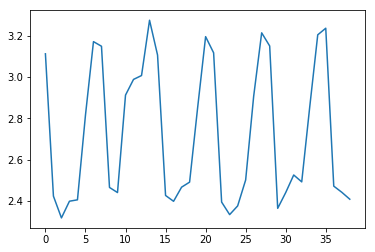

In [31]:
plt.plot(testpreds[129])

In [32]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [33]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.802841   
air_0164b9927d20bcc3_2017-04-23              1.447036   
air_0241aa3964b7f861_2017-04-23              2.333994   
air_0328696196e46f18_2017-04-23              2.129714   
air_034a3d5b40d5b1b1_2017-04-23              3.491170   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   5.066862  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.250497  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   9.319077  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.412457  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  31.824320

In [34]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [35]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [36]:
submission.to_csv("../submission/l3_3006_xgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')